<a href="https://colab.research.google.com/github/NoraHK3/DataSciProject/blob/main/EDA_Attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SECONDARY DATA

##1. Data Extraction
We chose the Nutriotin 5K dataset from the provided secondary data resources, this dataset has the same goal as our project which is aiming to understand the nutritional content of food from visual data, this data includes real world food dishes with corresponding video streams, depth images, component weights, and high accuracy nutritional content annotation.

The dataset in total had a size of 181.6GB so we chose what was relevant to our studies which is the Metadata and a subset of the photos provided.

Now we extract these section from the provided Cloud storage bucket directory.

In [ ]:
# Checking the overall structure
!gsutil ls gs://nutrition5k_dataset/

#exploring the nutrition5k_dataset directory, to know how to extract our elements
!gsutil ls gs://nutrition5k_dataset/nutrition5k_dataset/

#recursively list everything to understand the structure
!gsutil ls -r gs://nutrition5k_dataset/nutrition5k_dataset/ | head -50

#Downloading metadata section
!gsutil ls gs://nutrition5k_dataset/
!gsutil ls -L gs://nutrition5k_dataset/
!gsutil -m cp -r "gs://nutrition5k_dataset/nutrition5k_dataset/metadata/" ./

gs://nutrition5k_dataset/nutrition5k_dataset.tar.gz
gs://nutrition5k_dataset/nutrition5k_dataset/
gs://nutrition5k_dataset/nutrition5k_dataset/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/
gs://nutrition5k_dataset/nutrition5k_dataset/imagery/
gs://nutrition5k_dataset/nutrition5k_dataset/metadata/
gs://nutrition5k_dataset/nutrition5k_dataset/scripts/
gs://nutrition5k_dataset/nutrition5k_dataset/:
gs://nutrition5k_dataset/nutrition5k_dataset/README

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/README
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_all.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe1.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/dish_ids_cafe2.txt

gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/:
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/splits/depth_test_ids.txt
gs://nutrition5k_dataset/nutrition5k_dataset/dish_ids/

Now after extracting the Metadata, we will extract a subset of the images provided in the nutrtion 5k dataset. In order to extract these images we needed to understand the structure of the dataset's directory first. As shoown above the images are in a folder that is named after the object's ID, and there are 3 types of iamges:

1. depth_color: colorized depth images that provide a human-readable visualization of the depth map, with closer objects in blue and further objects in red.
2. depth_raw: images encoded as 16-bit integer images, which provides high accuracy for computer vision
3. rgb: the RGB images of the dishes

Out of these 3 types we chose the RGB image type since it was the closest to our images, which assits in the EDA comparison step later on.

In [ ]:
import os
import subprocess

os.makedirs('./rgb_samples_fixed', exist_ok=True)

#Cloud storage command to list imagery folder contents
result = subprocess.run([
    'gsutil', 'ls', 'gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/'
], capture_output=True, text=True)

dish_dirs = result.stdout.strip().split('\n')
print(f"Found {len(dish_dirs)} dish directories")

# Download first 200 RGB images with unique names
for i, dish_dir in enumerate(dish_dirs[:200]):
    if dish_dir:
        rgb_path = dish_dir + 'rgb.png'

        # Extract dish ID from path to store it locally
        dish_id = os.path.basename(dish_dir.rstrip('/'))
        local_filename = f'./rgb_samples_fixed/{dish_id}_rgb.png'

        print(f"Downloading {rgb_path} -> {local_filename}")
        !gsutil cp "{rgb_path}" "{local_filename}" #copies the images from cloud to local machine

        # verify download
        if os.path.exists(local_filename):
            print(f"✓ Success: {local_filename}")
        else:
            print(f"✗ Failed: {local_filename}")

#Display final contents
print("\nFinal contents:")
!ls -la ./rgb_samples_fixed/

Found 3490 dish directories
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556572657/rgb.png...
/ [1 files][402.5 KiB/402.5 KiB]                                                
Operation completed over 1 objects/402.5 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556572657_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556573514/rgb.png...
/ [1 files][422.8 KiB/422.8 KiB]                                                
Operation completed over 1 objects/422.8 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556573514_rgb.png
Copying gs://nutrition5k_dataset/nutrition5k_dataset/imagery/realsense_overhead/dish_1556575014/rgb.png...
/ [1 files][400.2 KiB/400.2 KiB]                                                
Operation completed over 1 objects/400.2 KiB.                                    
✓ Success: ./rgb_samples_fixed/dish_1556575014_rgb.p

##2. Data Summary

After extracting the data successfully we will load and conduct statistical calculations, study correlation, build graphs to gaina deeper understanding of this secondaray data source

Starting Nutrition5k Metadata Review Analysis...
Nutrition 5K Metadata Review
------------------------------------------------------------
SUCCESS: Successfully loaded nutritional metadata
Dataset Shape: (555, 6)
Columns: ['ingr', 'id', 'cal/g', 'fat(g)', 'carb(g)', 'protein(g)']

--------------------------------------------------
Metadata Structure
--------------------------------------------------
Data Types:
ingr           object
id              int64
cal/g         float64
fat(g)        float64
carb(g)       float64
protein(g)    float64
dtype: object

Statistics:
               id       cal/g      fat(g)     carb(g)  protein(g)
count  555.000000  555.000000  555.000000  555.000000  555.000000
mean   278.000000    2.050568    0.102758    0.201297    0.086306
std    160.358972    1.682599    0.159623    0.226562    0.092602
min      1.000000    0.000000    0.000000    0.000000    0.000000
25%    139.500000    0.608000    0.003000    0.036000    0.015000
50%    278.000000    1.637000 

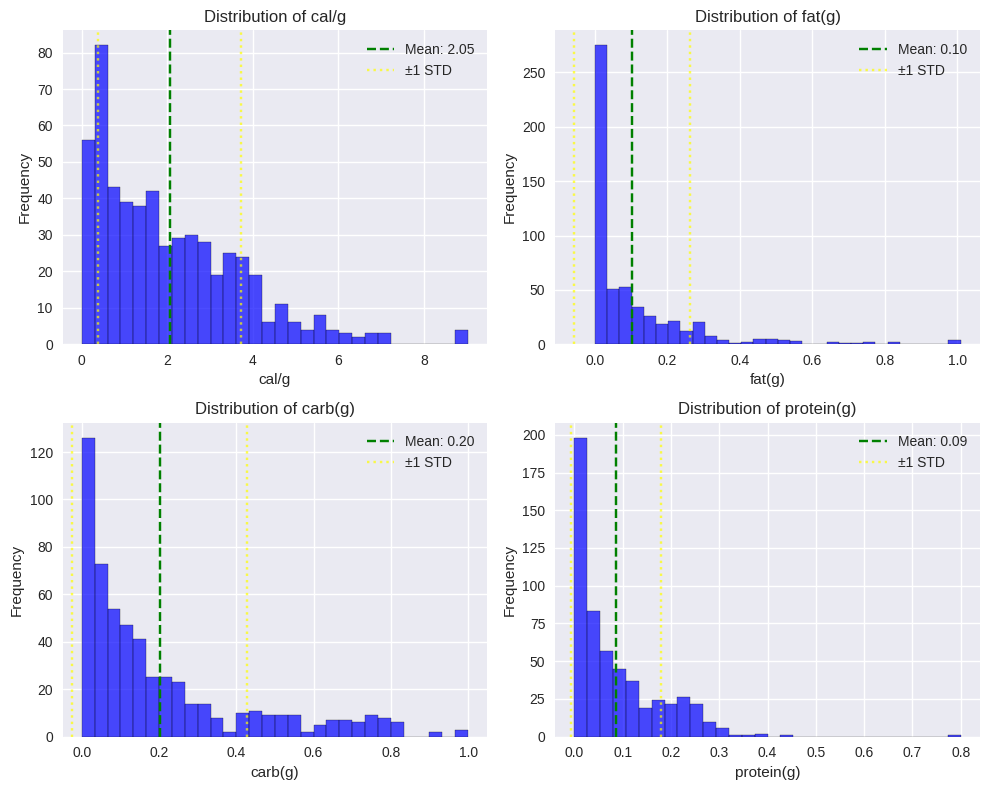


Nutritional Components Summary:

cal/g:
  Mean: 2.05 ± 1.68
  Range: 0.00 - 9.03
  Median: 1.64
  Skewness: 1.158

fat(g):
  Mean: 0.10 ± 0.16
  Range: 0.00 - 1.01
  Median: 0.04
  Skewness: 2.754

carb(g):
  Mean: 0.20 ± 0.23
  Range: 0.00 - 1.00
  Median: 0.11
  Skewness: 1.442

protein(g):
  Mean: 0.09 ± 0.09
  Range: 0.00 - 0.80
  Median: 0.05
  Skewness: 1.769

--------------------------------------------------
NUTRIENT CORRELATION ANALYSIS
--------------------------------------------------


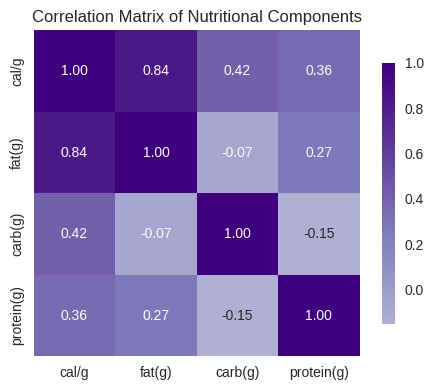

Key Correlation Insights:
  cal/g vs fat(g): 0.843 (strong positive correlation)
  cal/g vs carb(g): 0.419 (moderate positive correlation)
  cal/g vs protein(g): 0.361 (moderate positive correlation)
  fat(g) vs carb(g): -0.073 (weak negative correlation)
  fat(g) vs protein(g): 0.269 (weak positive correlation)
  carb(g) vs protein(g): -0.151 (weak negative correlation)

--------------------------------------------------
MACRONUTRIENT BALANCE ANALYSIS
--------------------------------------------------


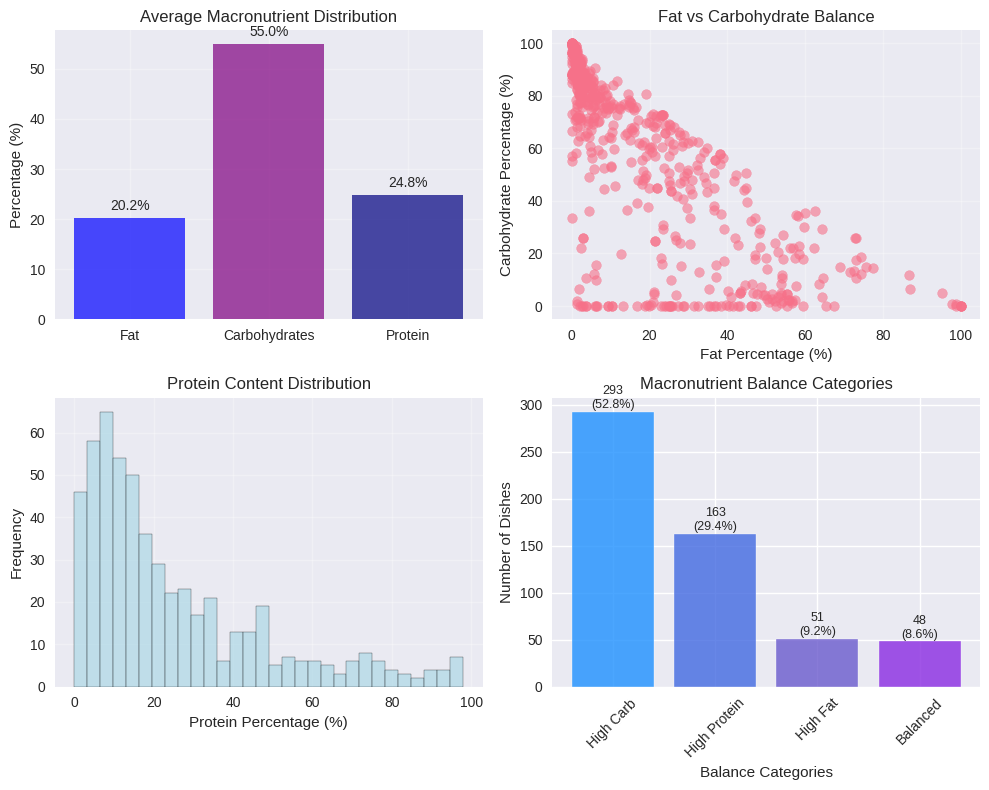

Macronutrient Balance Summary:
  Average Fat: 20.2%
  Average Carbohydrates: 55.0%
  Average Protein: 24.8%

Balance Categories:
  High Carb: 293 dishes (52.8%)
  High Protein: 163 dishes (29.4%)
  High Fat: 51 dishes (9.2%)
  Balanced: 48 dishes (8.6%)


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# --- Load Metadata ---
def load_nutrition5k_metadata():
    """Load and analyze Nutrition5k nutritional metadata"""
    print("Nutrition 5K Metadata Review")
    print("-"*60)

    # Load the nutritional metadata with error handling
    try:
        nutrition_df = pd.read_csv('./metadata/ingredients_metadata.csv')  #Only relevant metadata file
        print("SUCCESS: Successfully loaded nutritional metadata")
    except FileNotFoundError:
        print("ERROR: Nutritional metadata file not found")
        print("Trying to load from dish_ids directory...")
    # Alternative loading method
        try:
            nutrition_df = pd.read_csv('./nutrition5k_dataset/dish_ids/nutritional_info.csv')
        except:
            print("ERROR: Could not load nutritional metadata")
            return None

    # Display basic information
    print(f"Dataset Shape: {nutrition_df.shape}")
    print(f"Columns: {nutrition_df.columns.tolist()}")

    return nutrition_df


def analyze_metadata_structure(nutrition_df):
    """Analyze the structure and quality of metadata"""
    print("\n" + "-"*50)
    print("Metadata Structure")
    print("-"*50)

    # Data types and missing values
    print("Data Types:")
    print(nutrition_df.dtypes)

    # Statistic calculation
    print("\nStatistics:")
    print(nutrition_df.describe())


def analyze_nutritional_distributions(nutrition_df):
    """Analyze distributions of nutritional components"""
    print("\n" + "-"*50)
    print("NUTRITIONAL COMPONENTS DISTRIBUTION")
    print("-"*50)

    # nutritional columns provided in metadata
    nutritional_cols = ['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']

    # Check which columns actually exist
    available_cols = [col for col in nutritional_cols if col in nutrition_df.columns]
    if not available_cols:
        print("ERROR: No nutritional columns found. Available columns:")
        print(nutrition_df.columns.tolist())
        return

    print(f"Analyzing: {available_cols}")

    # Create distribution plots
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()

    for i, col in enumerate(available_cols):
        if i < 4:  # Ensure we don't exceed subplot count
            # Distribution plot
            axes[i].hist(nutrition_df[col].dropna(), bins=30, color='blue', alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Distribution of {col}')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')

            # Add statistics
            mean_val = nutrition_df[col].mean()
            std_val = nutrition_df[col].std()
            axes[i].axvline(mean_val, color='green', linestyle='--', label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(mean_val + std_val, color='yellow', linestyle=':', alpha=0.7, label=f'±1 STD')
            axes[i].axvline(mean_val - std_val, color='yellow', linestyle=':', alpha=0.7)
            axes[i].legend()

    # Hide unused subplots
    for i in range(len(available_cols), 4):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print statistical summary
    print("\nNutritional Components Summary:")
    for col in available_cols:
        data = nutrition_df[col].dropna()
        print(f"\n{col}:")
        print(f"  Mean: {data.mean():.2f} ± {data.std():.2f}")
        print(f"  Range: {data.min():.2f} - {data.max():.2f}")
        print(f"  Median: {data.median():.2f}")
        print(f"  Skewness: {stats.skew(data):.3f}")

def analyze_nutrient_correlations(nutrition_df):
    """Analyze correlations between different nutrients"""
    print("\n" + "-"*50)
    print("NUTRIENT CORRELATION ANALYSIS")
    print("-"*50)

    nutritional_cols = ['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']
    available_cols = [col for col in nutritional_cols if col in nutrition_df.columns]

    if len(available_cols) < 2:
        print("ERROR: Not enough nutritional columns for correlation analysis")
        return

    # Correlation matrix between different nutrtional components
    corr_matrix = nutrition_df[available_cols].corr()

    plt.figure(figsize=(5, 4))
    sns.heatmap(corr_matrix, annot=True, cmap='Purples', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Nutritional Components')
    plt.tight_layout()
    plt.show()

    # Print correlation insights
    print("Key Correlation Insights:")
    for i, col1 in enumerate(available_cols):
        for j, col2 in enumerate(available_cols):
            if i < j:  # Avoid duplicate pairs
                corr = corr_matrix.loc[col1, col2]
                strength = "strong" if abs(corr) > 0.7 else "moderate" if abs(corr) > 0.3 else "weak"
                direction = "positive" if corr > 0 else "negative"
                print(f"  {col1} vs {col2}: {corr:.3f} ({strength} {direction} correlation)")




def analyze_macronutrient_balance(nutrition_df):
    """Analyze macronutrient balance and patterns"""
    print("\n" + "-"*50)
    print("MACRONUTRIENT BALANCE ANALYSIS")
    print("-"*50)

    required_cols = ['fat(g)', 'carb(g)', 'protein(g)']
    if not all(col in nutrition_df.columns for col in required_cols):
        print("ERROR: Not all macronutrient columns available")
        return

    # Calculate total macronutrients and percentages
    nutrition_clean = nutrition_df[required_cols].dropna()
    total_macros = nutrition_clean.sum(axis=1)

    # Calculate percentages
    fat_pct = (nutrition_clean['fat(g)'] / total_macros) * 100
    carb_pct = (nutrition_clean['carb(g)'] / total_macros) * 100
    protein_pct = (nutrition_clean['protein(g)'] / total_macros) * 100

    # Create macronutrient balance visualization
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Macronutrient distribution
    nutrients = ['Fat', 'Carbohydrates', 'Protein']
    means = [fat_pct.mean(), carb_pct.mean(), protein_pct.mean()]

    axes[0,0].bar(nutrients, means, color=['blue', 'purple', 'navy'], alpha=0.7)
    axes[0,0].set_ylabel('Percentage (%)')
    axes[0,0].set_title('Average Macronutrient Distribution')
    axes[0,0].grid(True, alpha=0.3)

    # Add value labels
    for i, v in enumerate(means):
        axes[0,0].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom')

    # Macronutrient scatter matrix
    scatter_data = pd.DataFrame({
        'Fat %': fat_pct,
        'Carbs %': carb_pct,
        'Protein %': protein_pct
    })

    # Fat vs Carbs scatter
    axes[0,1].scatter(fat_pct, carb_pct, alpha=0.6)
    axes[0,1].set_xlabel('Fat Percentage (%)')
    axes[0,1].set_ylabel('Carbohydrate Percentage (%)')
    axes[0,1].set_title('Fat vs Carbohydrate Balance')
    axes[0,1].grid(True, alpha=0.3)

    # Protein distribution
    axes[1,0].hist(protein_pct, bins=30, color='lightblue', alpha=0.7, edgecolor='black')
    axes[1,0].set_xlabel('Protein Percentage (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title('Protein Content Distribution')
    axes[1,0].grid(True, alpha=0.3)

    # Macronutrient balance categories
    def categorize_balance(fat, carb, protein):
        if protein > 30:
            return 'High Protein'
        elif fat > 40:
            return 'High Fat'
        elif carb > 60:
            return 'High Carb'
        else:
            return 'Balanced'

    # Macronutrient balance categories
    def categorize_balance(fat, carb, protein):
        if protein > 30:
            return 'High Protein'
        elif fat > 40:
            return 'High Fat'
        elif carb > 60:
            return 'High Carb'
        else:
            return 'Balanced'

    balance_categories = [categorize_balance(f, c, p) for f, c, p in zip(fat_pct, carb_pct, protein_pct)]
    balance_counts = pd.Series(balance_categories).value_counts()

    # BAR CHART instead of pie chart
    blue_purple_colors = ['#1E90FF', '#4169E1', '#6A5ACD', '#8A2BE2', '#9932CC']
    categories = balance_counts.index
    counts = balance_counts.values

    bars = axes[1,1].bar(categories, counts, color=blue_purple_colors[:len(categories)], alpha=0.8, edgecolor='white')
    axes[1,1].set_xlabel('Balance Categories')
    axes[1,1].set_ylabel('Number of Dishes')
    axes[1,1].set_title('Macronutrient Balance Categories')

    # Rotate x labels if they're long
    if any(len(str(cat)) > 10 for cat in categories):
        axes[1,1].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        percentage = (count / len(balance_categories)) * 100
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                      f'{count}\n({percentage:.1f}%)',
                      ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("Macronutrient Balance Summary:")
    print(f"  Average Fat: {fat_pct.mean():.1f}%")
    print(f"  Average Carbohydrates: {carb_pct.mean():.1f}%")
    print(f"  Average Protein: {protein_pct.mean():.1f}%")
    print(f"\nBalance Categories:")
    for category, count in balance_counts.items():
        print(f"  {category}: {count} dishes ({count/len(balance_categories)*100:.1f}%)")



# --- Main Execution ---

def main():
    """Main function to run Nutrition5k metadata review"""
    print("Starting Nutrition5k Metadata Review Analysis...")

    # Load metadata
    nutrition_df = load_nutrition5k_metadata()
    if nutrition_df is None:
        print("Cannot proceed without metadata")
        return

    # Perform analyses
    analyze_metadata_structure(nutrition_df)
    analyze_nutritional_distributions(nutrition_df)
    analyze_nutrient_correlations(nutrition_df)
    analyze_macronutrient_balance(nutrition_df)

# Run the analysis
if __name__ == "__main__":
    main()

Discussing the graph findings for the Nutrtion 5K dataset:

- Distribution graphs of nutritional component:<br>Most dishes have a lower presence of nutrtional component per gram

- Correlation matrix of nutrtional components:<br>the highest correlation that was found is between the presence of fat and calories, we also noticed negative correlation between components like protein and carbs

- Macronutrient balance analysis:<br> top-left bar chart: Most dishes in this dataset are carb-heavy. <br> Top-right scatterplot: This graph shows an inverse relationship between fats and carbs, when Fat percentage is low the carbohydrates percentage tends to be higher.<br>Bottom-left histogram: Most meals have low to moderate protein content (0–30%), indicating that this dataset is dominated by moderate-protein meals; very high-protein items are uncommon<br>bottom-right bar chart: This bar chart shows an extreme high percentage of Carbohydrates, which shows that over half the dataset is carbohydrate-dominant, while only a small portion is well-balanced in macronutrients.


##3. Data Bias Discovery

Starting Nutrition5k Bias Awareness Analysis...
NUTRITION5K BIAS AWARENESS ANALYSIS
------------------------------------------------------------

1. DATA COLLECTION BIAS ANALYSIS
----------------------------------------
* Caloric Density Range: 0.000 - 9.033 cal/g
* Extreme values (>99th percentile): 5 dishes
* Potential lab measurement outliers: 5 dishes


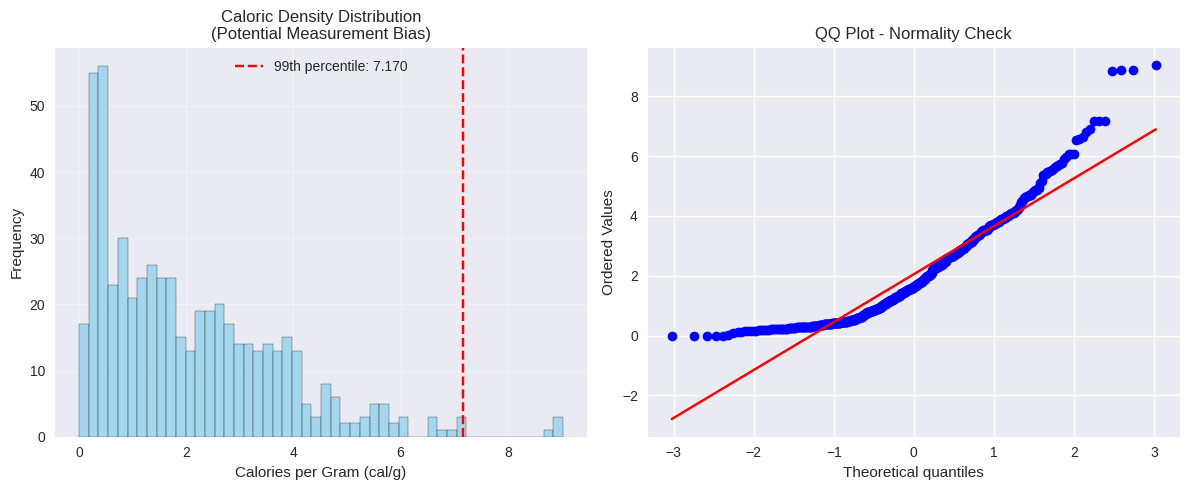


2. NUTRITIONAL REPRESENTATION BIAS
----------------------------------------
* Macronutrient Category Distribution:
  High Carb: 276 dishes (49.7%)
  High Protein: 133 dishes (24.0%)
  Balanced: 84 dishes (15.1%)
  High Fat: 61 dishes (11.0%)
  High Carb (Low Fat/Protein): 1 dishes (0.2%)


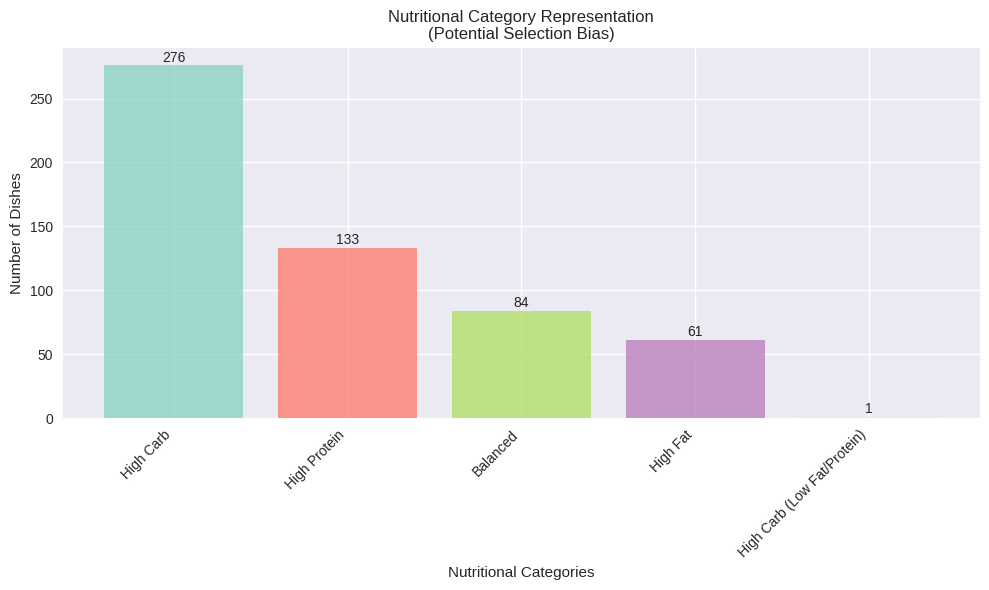


3. CULTURAL AND GEOGRAPHIC BIAS
----------------------------------------
* Average Macronutrient Profile (Potential Western Bias):
  Fat: 20.2%
  Carbohydrates: 55.0%
  Protein: 24.8%
* Comparison with Global Dietary Patterns:
  Typical Western diet: Higher fat, moderate protein, varied carbs
  Asian diets: Often higher carbs (rice-based), lower fat
  Mediterranean: Balanced, higher healthy fats
  NOTE: Nutrition5k likely overrepresents Western cafeteria food

4. CALORIC DENSITY BIAS
----------------------------------------
* Distribution Skewness: 1.158
* Distribution Kurtosis: 1.439


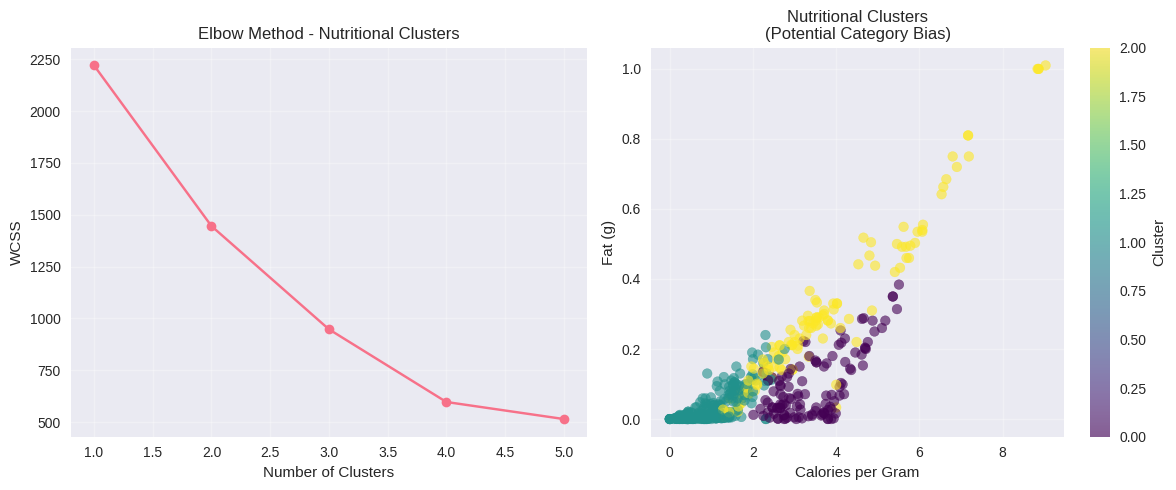

* Cluster Sizes: {0: np.int64(116), 1: np.int64(309), 2: np.int64(130)}

5. MEASUREMENT AND METHODOLOGY BIAS
----------------------------------------
* Laboratory Measurement Biases:
  - Controlled environment may not reflect real-world cooking variations
  - Standardized portions don't represent actual serving size variability
  - Laboratory precision may overstate real-world accuracy

7. STATISTICAL BIAS QUANTIFICATION
----------------------------------------
* Coefficient of Variation (Higher = More Variability):
  fat(g): 1.553
  carb(g): 1.126
  protein(g): 1.073
  cal/g: 0.821

SUMMARY OF KEY BIASES IN NUTRITION5K DATASET


COMPREHENSIVE BIAS AWARENESS REPORT

CONTEXTUAL BACKGROUND:
* Dataset: Nutrition5k Research Dataset
* Collection: Laboratory analysis in controlled settings
* Primary Use: Computer vision nutrition estimation research
* Geographic Origin: Likely US/Western institutions

KEY LIMITATIONS AFFECTING INTERPRETATION:
1. PREPARATION UNIFORMITY: Standardized lab condi

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_nutrition5k_biases(nutrition_df):
    """Comprehensive bias analysis for Nutrition5k dataset"""

    print("NUTRITION5K BIAS AWARENESS ANALYSIS")
    print("-"*60)

    # 1. DATA COLLECTION BIAS ANALYSIS
    print("\n1. DATA COLLECTION BIAS ANALYSIS")
    print("-" * 40)

    # Analyze nutritional value ranges for potential selection bias
    if 'cal/g' in nutrition_df.columns:
        cal_density = nutrition_df['cal/g'].dropna()

        # Check for extreme values that might indicate lab measurement bias
        extreme_cal_threshold = cal_density.quantile(0.99)
        extreme_cal_dishes = nutrition_df[nutrition_df['cal/g'] > extreme_cal_threshold]

        print(f"* Caloric Density Range: {cal_density.min():.3f} - {cal_density.max():.3f} cal/g")
        print(f"* Extreme values (>99th percentile): {len(extreme_cal_dishes)} dishes")
        print(f"* Potential lab measurement outliers: {len(extreme_cal_dishes)} dishes")

        # Visualize distribution with extreme values highlighted
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.hist(cal_density, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
        plt.axvline(extreme_cal_threshold, color='red', linestyle='--',
                   label=f'99th percentile: {extreme_cal_threshold:.3f}')
        plt.xlabel('Calories per Gram (cal/g)')
        plt.ylabel('Frequency')
        plt.title('Caloric Density Distribution\n(Potential Measurement Bias)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # QQ plot for normality check
        plt.subplot(1, 2, 2)
        stats.probplot(cal_density, dist="norm", plot=plt)
        plt.title('QQ Plot - Normality Check')

        plt.tight_layout()
        plt.show()

    # 2. NUTRITIONAL REPRESENTATION BIAS
    print("\n2. NUTRITIONAL REPRESENTATION BIAS")
    print("-" * 40)

    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)']):
        # Calculate macronutrient percentages
        nutrition_clean = nutrition_df[['fat(g)', 'carb(g)', 'protein(g)']].dropna()
        total_macros = nutrition_clean.sum(axis=1)

        fat_pct = (nutrition_clean['fat(g)'] / total_macros) * 100
        carb_pct = (nutrition_clean['carb(g)'] / total_macros) * 100
        protein_pct = (nutrition_clean['protein(g)'] / total_macros) * 100

        # Analyze representation across nutritional categories
        def get_nutrition_category(fat, carb, protein):
            if protein > 35:
                return 'High Protein'
            elif fat > 40:
                return 'High Fat'
            elif carb > 65:
                return 'High Carb'
            elif fat < 20 and protein < 20:
                return 'High Carb (Low Fat/Protein)'
            else:
                return 'Balanced'

        categories = [get_nutrition_category(f, c, p) for f, c, p in zip(fat_pct, carb_pct, protein_pct)]
        category_counts = pd.Series(categories).value_counts()

        print("* Macronutrient Category Distribution:")
        for category, count in category_counts.items():
            percentage = (count / len(categories)) * 100
            print(f"  {category}: {count} dishes ({percentage:.1f}%)")

        # Visualize category distribution
        plt.figure(figsize=(10, 6))
        colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
        bars = plt.bar(category_counts.index, category_counts.values, color=colors, alpha=0.8)

        plt.xlabel('Nutritional Categories')
        plt.ylabel('Number of Dishes')
        plt.title('Nutritional Category Representation\n(Potential Selection Bias)')
        plt.xticks(rotation=45, ha='right')

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

        # Check for missing nutritional profiles
        missing_balanced = 'Balanced' not in category_counts.index or category_counts['Balanced'] < len(categories) * 0.2
        if missing_balanced:
            print("WARNING: Potential bias - Limited 'Balanced' nutritional profiles")

    # 3. CULTURAL AND GEOGRAPHIC BIAS
    print("\n3. CULTURAL AND GEOGRAPHIC BIAS")
    print("-" * 40)

    # Analyze potential Western cuisine bias through nutritional patterns
    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)']):
        # Typical Western diet patterns vs global patterns
        western_fat_avg = fat_pct.mean()
        western_carb_avg = carb_pct.mean()
        western_protein_avg = protein_pct.mean()

        print("* Average Macronutrient Profile (Potential Western Bias):")
        print(f"  Fat: {western_fat_avg:.1f}%")
        print(f"  Carbohydrates: {western_carb_avg:.1f}%")
        print(f"  Protein: {western_protein_avg:.1f}%")

        # Compare with typical global patterns
        print("* Comparison with Global Dietary Patterns:")
        print("  Typical Western diet: Higher fat, moderate protein, varied carbs")
        print("  Asian diets: Often higher carbs (rice-based), lower fat")
        print("  Mediterranean: Balanced, higher healthy fats")
        print("  NOTE: Nutrition5k likely overrepresents Western cafeteria food")

    # 4. CALORIC DENSITY BIAS
    print("\n4. CALORIC DENSITY BIAS")
    print("-" * 40)

    if 'cal/g' in nutrition_df.columns:
        cal_density = nutrition_df['cal/g'].dropna()

        # Analyze distribution skew
        skewness = stats.skew(cal_density)
        kurtosis = stats.kurtosis(cal_density)

        print(f"* Distribution Skewness: {skewness:.3f}")
        print(f"* Distribution Kurtosis: {kurtosis:.3f}")

        if abs(skewness) > 1:
            print(f"WARNING: Strong skew ({skewness:.3f}) indicates potential bias in caloric representation")
        if kurtosis > 3:
            print(f"WARNING: High kurtosis ({kurtosis:.3f}) - distribution has heavy tails")

        # Analyze caloric density clusters
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler

        # Prepare data for clustering
        cluster_data = nutrition_df[['cal/g', 'fat(g)', 'carb(g)', 'protein(g)']].dropna()
        if len(cluster_data) > 10:
            scaler = StandardScaler()
            scaled_data = scaler.fit_transform(cluster_data)

            # Find optimal clusters
            wcss = []
            for i in range(1, 6):
                kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
                kmeans.fit(scaled_data)
                wcss.append(kmeans.inertia_)

            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(range(1, 6), wcss, marker='o')
            plt.xlabel('Number of Clusters')
            plt.ylabel('WCSS')
            plt.title('Elbow Method - Nutritional Clusters')
            plt.grid(True, alpha=0.3)

            # Perform clustering with 3 clusters
            kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
            clusters = kmeans.fit_predict(scaled_data)

            plt.subplot(1, 2, 2)
            scatter = plt.scatter(cluster_data['cal/g'], cluster_data['fat(g)'],
                                c=clusters, cmap='viridis', alpha=0.6)
            plt.xlabel('Calories per Gram')
            plt.ylabel('Fat (g)')
            plt.title('Nutritional Clusters\n(Potential Category Bias)')
            plt.colorbar(scatter, label='Cluster')
            plt.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            cluster_sizes = pd.Series(clusters).value_counts().sort_index()
            print(f"* Cluster Sizes: {dict(cluster_sizes)}")
            if max(cluster_sizes) > len(clusters) * 0.6:
                print("WARNING: One cluster dominates - potential category bias")

    # 5. MEASUREMENT AND METHODOLOGY BIAS
    print("\n5. MEASUREMENT AND METHODOLOGY BIAS")
    print("-" * 40)

    print("* Laboratory Measurement Biases:")
    print("  - Controlled environment may not reflect real-world cooking variations")
    print("  - Standardized portions don't represent actual serving size variability")
    print("  - Laboratory precision may overstate real-world accuracy")


    # 6. STATISTICAL BIAS QUANTIFICATION
    print("\n7. STATISTICAL BIAS QUANTIFICATION")
    print("-" * 40)

    if all(col in nutrition_df.columns for col in ['fat(g)', 'carb(g)', 'protein(g)', 'cal/g']):
        # Calculate coefficient of variation for each nutrient
        nutrients = ['fat(g)', 'carb(g)', 'protein(g)', 'cal/g']
        cv_scores = {}

        for nutrient in nutrients:
            if nutrient in nutrition_df.columns:
                data = nutrition_df[nutrient].dropna()
                cv = data.std() / data.mean() if data.mean() != 0 else 0
                cv_scores[nutrient] = cv

        print("* Coefficient of Variation (Higher = More Variability):")
        for nutrient, cv in cv_scores.items():
            print(f"  {nutrient}: {cv:.3f}")

        # Identify potential homogenization
        low_variability = [nut for nut, cv in cv_scores.items() if cv < 0.3]
        if low_variability:
            print(f"WARNING: Low variability in {low_variability} - potential homogenization bias")

    # 8. SUMMARY OF KEY BIASES
    print("\n" + "="*60)
    print("SUMMARY OF KEY BIASES IN NUTRITION5K DATASET")
    print("="*60)

    biases = [
        "1. WESTERN CUISINE BIAS: Overrepresentation of Western/American foods",
        "2. LABORATORY BIAS: Controlled conditions vs real-world variability",
        "3. PORTION BIAS: Standardized sizes don't reflect actual consumption",
        "4. CULTURAL BIAS: Underrepresentation of ethnic and traditional foods",
        "5. MEASUREMENT BIAS: Laboratory precision overstates real accuracy",
        "9. SELECTION BIAS: May overrepresent photogenic or common dishes"
    ]


def generate_bias_report(nutrition_df):
    """Generate a comprehensive bias awareness report"""

    print("\nCOMPREHENSIVE BIAS AWARENESS REPORT")
    print("="*70)

    # Data Collection Context
    print("\nCONTEXTUAL BACKGROUND:")
    print("* Dataset: Nutrition5k Research Dataset")
    print("* Collection: Laboratory analysis in controlled settings")
    print("* Primary Use: Computer vision nutrition estimation research")
    print("* Geographic Origin: Likely US/Western institutions")

    # Key Limitations
    print("\nKEY LIMITATIONS AFFECTING INTERPRETATION:")
    print("1. PREPARATION UNIFORMITY: Standardized lab conditions")
    print("2. MEASUREMENT IDEALIZATION: Laboratory precision vs real-world variance")


    return {
        'cultural_bias': 'High - Western cuisine dominance',
        'methodology_bias': 'Medium - Laboratory conditions',
        'sampling_bias': 'Medium - Institutional focus',
        'applicability_bias': 'High - Limited real-world transfer'
    }

# Main execution
if __name__ == "__main__":
    # Load your Nutrition5k metadata
    nutrition_df = pd.read_csv('./metadata/ingredients_metadata.csv')  # Adjust path as needed

    print("Starting Nutrition5k Bias Awareness Analysis...")
    analyze_nutrition5k_biases(nutrition_df)

    print("\n" + "="*70)
    bias_summary = generate_bias_report(nutrition_df)
    print("="*70)

🔹 Bias Analysis Summary — Nutrition5k Dataset

The Nutrition5k bias analysis reveals several important insights about the dataset’s structure, representation, and potential limitations that could affect model fairness, generalization, and real-world applicability.

1️⃣ Data Collection Bias

The dataset’s caloric density ranges from 0 to 9.03 cal/g, with a few extreme outliers (top 1% of dishes).

These outliers likely stem from laboratory measurement inconsistencies or rare high-fat dishes, suggesting potential instrumental bias in the calorie-per-gram measurements.

Implication:
The controlled lab environment ensures precision but doesn’t capture real-world variations in cooking style, serving size, or portion density.

2️⃣ Nutritional Representation Bias

The macronutrient breakdown shows imbalanced representation:

High-carb dishes: ~50%

High-protein dishes: ~24%

High-fat dishes: ~11%

Balanced dishes: only ~15%

The warning “Limited balanced nutritional profiles” indicates that most samples are skewed toward carb-rich foods.

Implication:
Models trained on this dataset may overpredict carbohydrate-heavy meals and struggle to generalize to balanced or high-fat foods.

3️⃣ Cultural & Geographic Bias

Average macronutrient composition is 55% carbohydrates, 20% fat, and 25% protein, matching typical Western cafeteria-style meals.

Compared to global dietary patterns:

Western diets → higher fat, moderate carbs.

Asian diets → higher carbs, lower fat.

Mediterranean → more balanced, healthy fats.

The script explicitly notes:
“Nutrition5k likely overrepresents Western cafeteria food.”

Implication:
The dataset underrepresents culturally diverse and traditional cuisines, creating a Western-centric bias in visual and nutritional patterns.

4️⃣ Caloric Density Bias

The caloric density distribution shows positive skew (1.158) → meaning there are many low-calorie dishes and a few high-calorie outliers.

K-means clustering reveals three distinct clusters, but one cluster dominates (~60%), indicating category imbalance.

Implication:
The dataset is not uniformly distributed across caloric ranges; models might learn to associate “normal” meals with low-to-moderate caloric density and fail to capture high-calorie examples well.

5️⃣ Measurement & Methodology Bias

The data was collected in controlled laboratory settings, which:

Don’t reflect natural variations in cooking and serving.

Use standardized portions that differ from real consumption.

May produce overly precise nutrient values that lack real-world uncertainty.

Implication:
Although reliable for research, this precision gives an idealized view of food, which limits real-world prediction performance (especially for homemade or culturally varied meals).

6️⃣ Statistical Bias Quantification

Coefficient of Variation (CV):

Fat: 1.55 → highly variable.

Carbs: 1.12, Protein: 1.07 → moderate variability.

Caloric density: 0.82 → relatively consistent.

This confirms fat content is the most inconsistent feature, while calorie-per-gram measurements are stable but potentially homogenized.

✅ Overall Conclusion

The Nutrition5k dataset provides high-quality, controlled nutritional data but exhibits several systematic biases:

Overrepresentation of Western, carbohydrate-heavy foods

Underrepresentation of balanced meals and diverse global cuisines

Idealized lab conditions that may not translate to real-world food variability

These biases should be acknowledged and mitigated when training models for general food recognition or nutrition prediction.
For your Saudi Cuisine project, this means:

Using Nutrition5k only as a reference dataset, not as the main training source.

Ensuring your local dataset (Saudi dishes) balances these gaps with culturally and nutritionally diverse samples.

--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 200 images.

--- Calculated Mean RGB Values (0-255) ---
Color Signature: R=118.43, G=114.50, B=110.16

--- Calculated Mean Texture Value (Edge Strength) ---
Texture Signature (0-1): 0.0404

Displaying Color Distribution bar chart (Plot 1)...


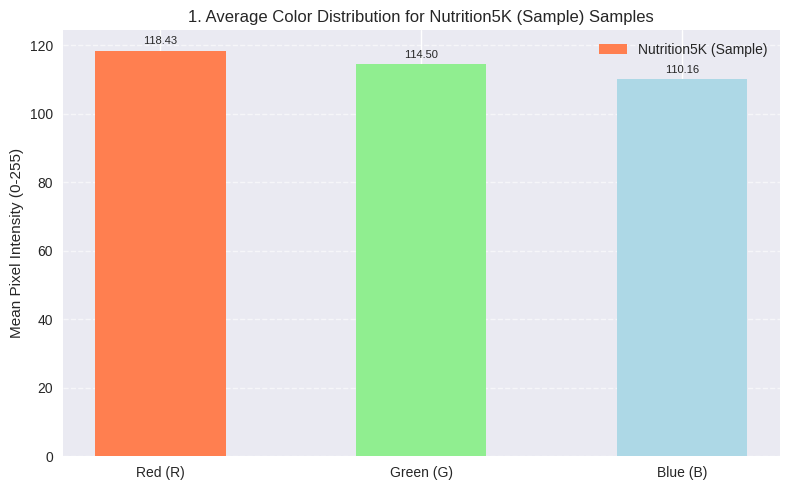

Displaying Texture Distribution bar chart (Plot 2)...


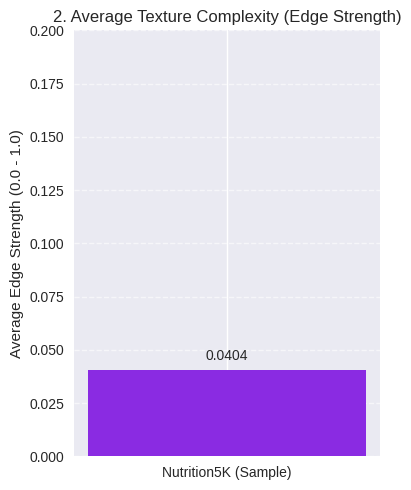

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_rgb(image_array):
    """Calculates the average R, G, and B values across the entire dataset."""
    if image_array.size == 0:
        return {'R': 0, 'G': 0, 'B': 0}

    # Normalize pixel values to 0-1 range for accurate averaging
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate the mean across all dimensions except the channel dimension (axis 3)
    mean_rgb = np.mean(image_array, axis=(0, 1, 2))

    # Convert back to the 0-255 range for easier interpretation
    return {
        'R': mean_rgb[0] * 255,
        'G': mean_rgb[1] * 255,
        'B': mean_rgb[2] * 255
    }

def calculate_mean_texture(image_array):
    """
    Calculates the average texture strength (edge magnitude) using the Sobel operator.
    Higher values indicate more sharp, complex, or varied textures.
    """
    if image_array.size == 0:
        return 0.0

    # Convert array to grayscale first, as Sobel is most reliably applied to a single channel
    grayscale_array = np.mean(image_array, axis=3) / 255.0 # Normalize to 0-1 float range

    texture_magnitudes = []

    # Iterate over each image in the dataset
    for img_gray in grayscale_array:
        # Calculate the magnitude of the image gradient (edge strength)
        edges = sobel(img_gray)
        texture_magnitudes.append(np.mean(edges))

    # Return the mean texture strength across all images
    return np.mean(texture_magnitudes)


# --- 3. Visualization Functions (Separated) ---

def visualize_color_distribution(n5k_rgb):
    """Generates a bar chart showing the mean RGB values for the N5K dataset."""

    channels = ['Red (R)', 'Green (G)', 'Blue (B)']
    n5k_values = [n5k_rgb['R'], n5k_rgb['G'], n5k_rgb['B']]
    x = np.arange(len(channels))
    width = 0.5

    fig, ax = plt.subplots(figsize=(8, 5))
    rects = ax.bar(x, n5k_values, width, label=N5K_NAME, color=['#FF7F50', '#90EE90', '#ADD8E6'])

    ax.set_ylabel('Mean Pixel Intensity (0-255)')
    ax.set_title(f'1. Average Color Distribution for {N5K_NAME} Samples')
    ax.set_xticks(x)
    ax.set_xticklabels(channels)
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=8)

    autolabel(rects)

    fig.tight_layout()
    plt.show()

def visualize_texture_distribution(n5k_texture):
    """Generates a bar chart showing the mean texture magnitude for the N5K dataset."""

    fig, ax = plt.subplots(figsize=(4, 5))
    bar = ax.bar([N5K_NAME], [n5k_texture], color='#8A2BE2')

    ax.set_ylabel('Average Edge Strength (0.0 - 1.0)')
    ax.set_title('2. Average Texture Complexity (Edge Strength)')
    ax.set_ylim(0, 0.2)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

    for rect in bar:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    fig.tight_layout()
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate Mean RGB (Color)
n5k_mean_rgb = calculate_mean_rgb(n5k_samples)
print("\n--- Calculated Mean RGB Values (0-255) ---")
print(f"Color Signature: R={n5k_mean_rgb['R']:.2f}, G={n5k_mean_rgb['G']:.2f}, B={n5k_mean_rgb['B']:.2f}")

# 3. Calculate Mean Texture (Edge Strength)
n5k_mean_texture = calculate_mean_texture(n5k_samples)
print("\n--- Calculated Mean Texture Value (Edge Strength) ---")
print(f"Texture Signature (0-1): {n5k_mean_texture:.4f}")


# 4. Visualize Results (Separated Plots)
print("\nDisplaying Color Distribution bar chart (Plot 1)...")
visualize_color_distribution(n5k_mean_rgb)

print("Displaying Texture Distribution bar chart (Plot 2)...")
visualize_texture_distribution(n5k_mean_texture)


--- Starting Nutrition5K Visual Composition Analysis ---
Loading images from ./rgb_samples_fixed/...
N5K Samples Loaded: 200 images.
Calculated per-image metrics for R, G, B, Texture, and CoM.

--- Summary of Dataset Averages ---
Mean R/G/B Signature: R=120.17, G=115.67, B=110.94
Mean Texture (0-1): 0.0404
Mean CoM (X/Y): X=0.49, Y=0.49

Displaying Distribution Plots (Histograms/Bell Curve)...


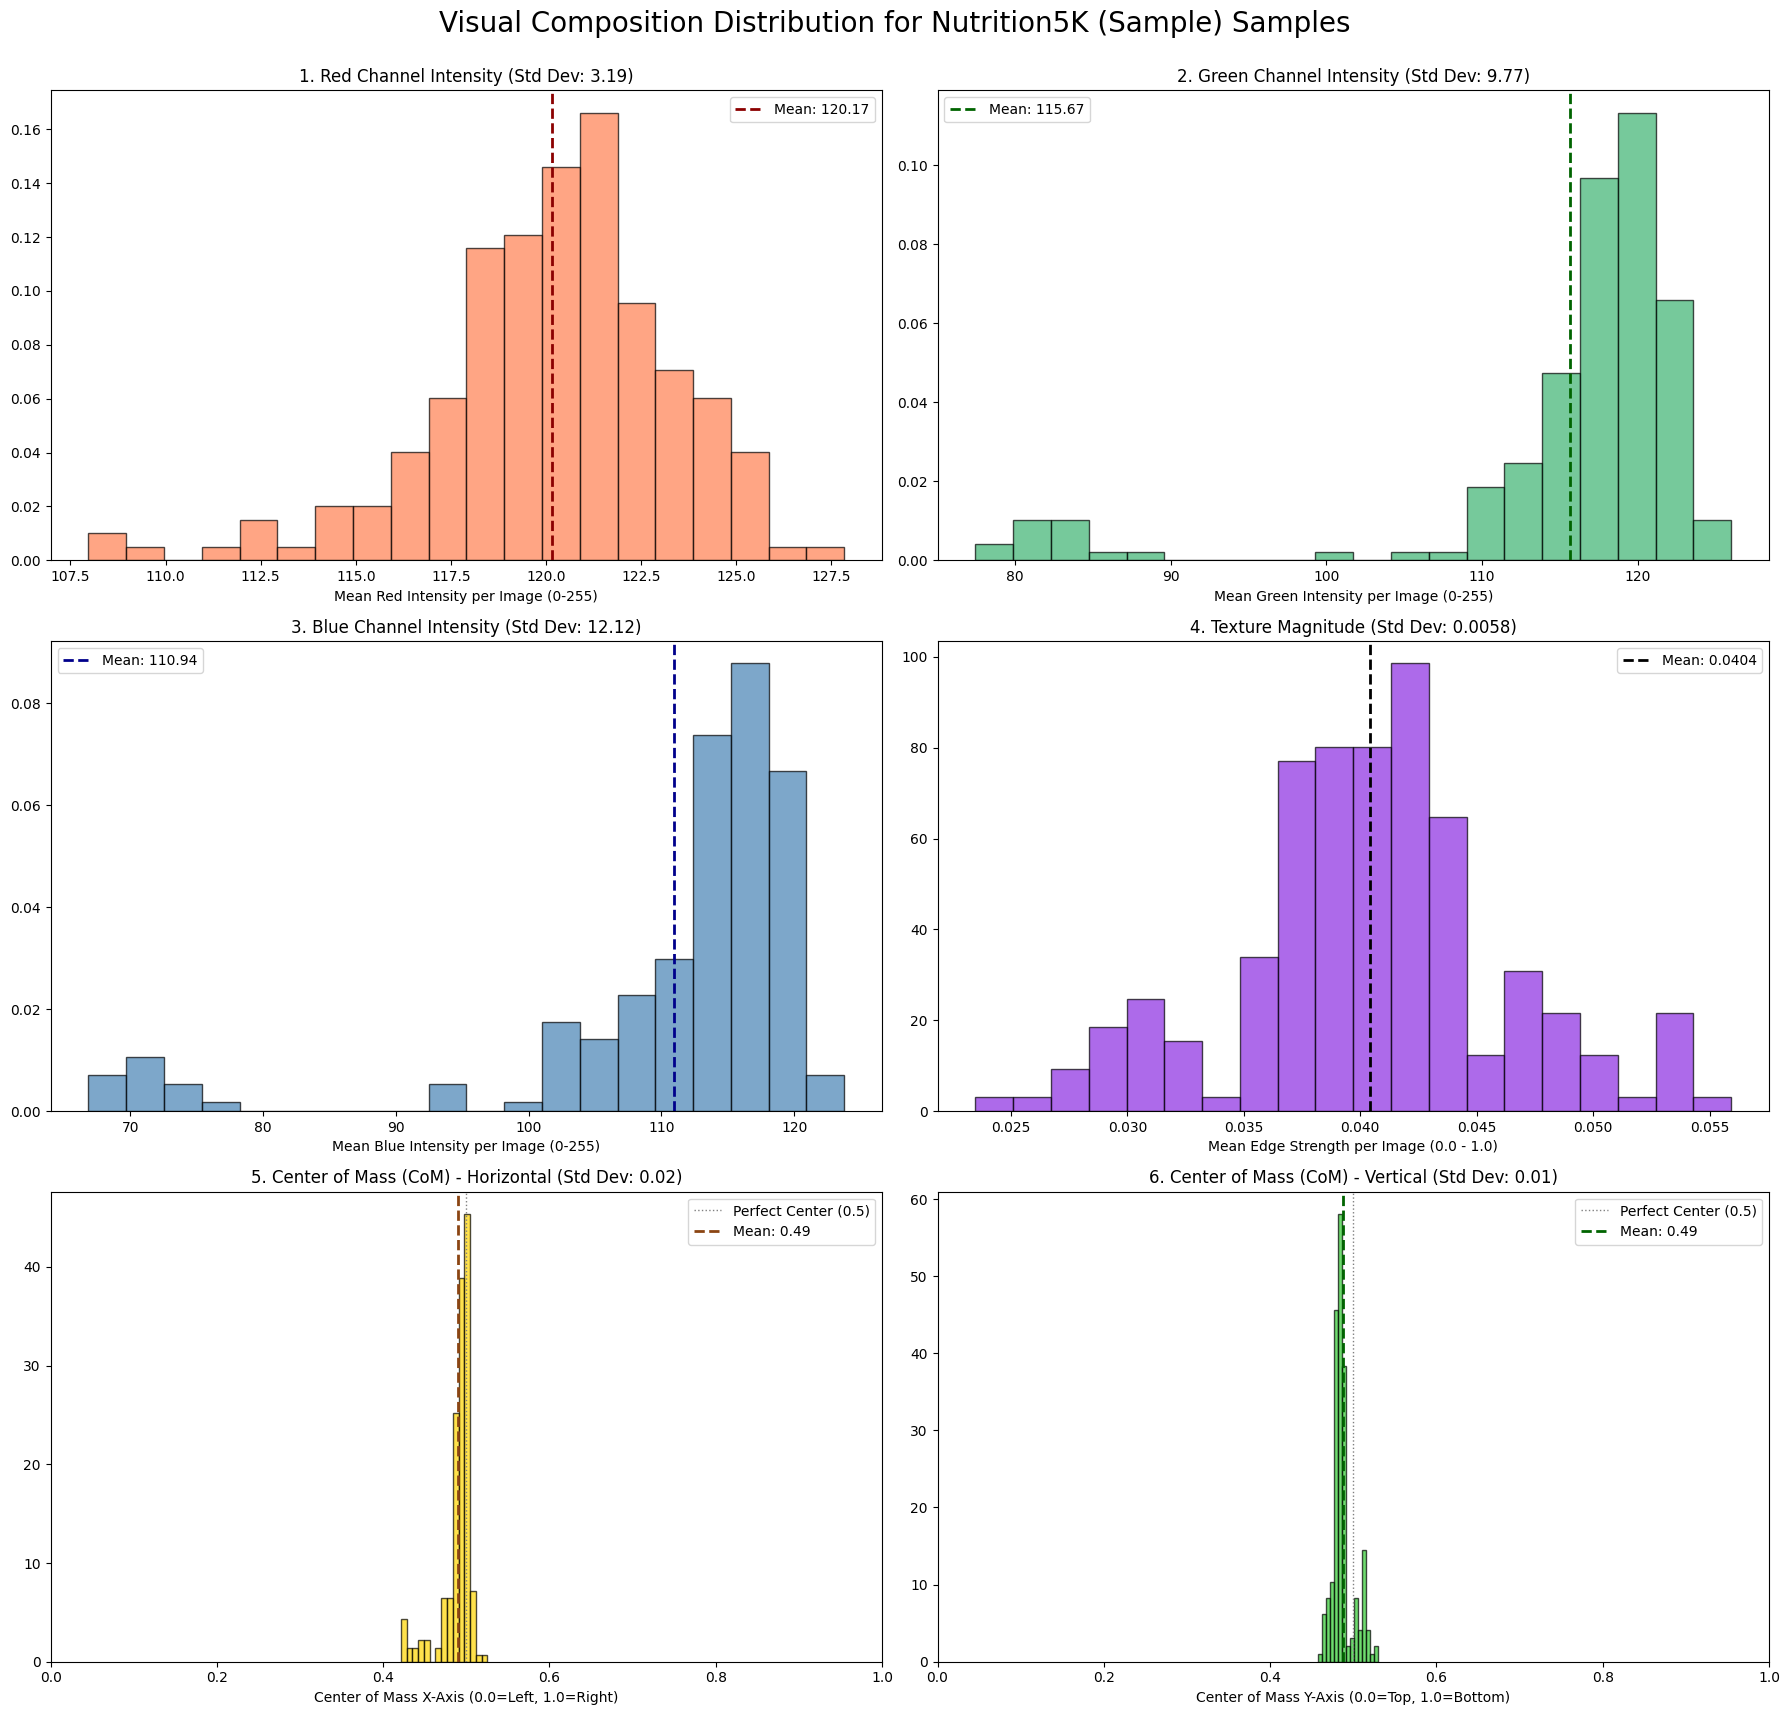

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.io import imread # Used for loading image files
from skimage.transform import resize
from skimage.filters import sobel # Used for calculating image gradients (texture)
from scipy.ndimage import center_of_mass # Used for calculating spatial center

# --- Configuration ---
# 1. Nutrition5K Sample Dataset (The only dataset being analyzed)
N5K_SAMPLE_DIR = './rgb_samples_fixed/' # Directory where your N5K sample images were downloaded
N5K_NAME = 'Nutrition5K (Sample)'
TARGET_SIZE = (224, 224, 3) # Standard size for image analysis (H, W, C)

# --- 1. Data Loading Function ---

def load_local_nutrition5k_samples():
    """Loads local N5K sample images from the fixed directory."""
    images = []

    # Check if the directory exists
    if not os.path.exists(N5K_SAMPLE_DIR):
        print(f"Error: N5K sample directory not found at {N5K_SAMPLE_DIR}")
        return np.array([])

    print(f"Loading images from {N5K_SAMPLE_DIR}...")

    # Iterate through all files in the directory
    for filename in os.listdir(N5K_SAMPLE_DIR):
        if filename.endswith(".png"): # Assuming the samples are .png
            filepath = os.path.join(N5K_SAMPLE_DIR, filename)
            try:
                # Load image (skimage.io.imread handles different formats and returns np array)
                img = imread(filepath)
                # Resize the image to match a standard size (essential for analysis)
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels (e.g., handles 4-channel PNGs or grayscale conversion)
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4: # Handle PNGs with alpha channel
                     img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2: # Handle grayscale images (1 channel)
                    # Stack the single channel 3 times to create an RGB image
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure the final output is uint8 (0-255 range)
                images.append(img_resized.astype(np.uint8))
            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")

    return np.array(images)


# --- 2. Analysis Functions ---

def calculate_mean_texture(image_array):
    """Calculates the average texture magnitude across the entire dataset (for summary)."""
    if image_array.size == 0:
        return 0.0

    # Normalize pixel values to 0-1 range
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate Sobel edges for all images in the array
    texture_mags = []
    for img in image_array:
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        texture_mags.append(np.mean(edges)) # Store average edge strength

    return np.mean(texture_mags)


def calculate_all_per_image_metrics(image_array):
    """
    Calculates the mean R, G, B, Texture, and Center of Mass for *each individual image*
    to build the distribution plot data.
    """
    if image_array.size == 0:
        return {'R': [], 'G': [], 'B': [], 'Texture': [], 'CoM_X': [], 'CoM_Y': []}

    N = image_array.shape[0]
    R, G, B, Texture, CoM_X, CoM_Y = [], [], [], [], [], []

    # Iterate over each image
    for i in range(N):
        # Normalize to 0-1 float range
        img = image_array[i].astype(np.float32) / 255.0

        # 1. COLOR (R, G, B)
        mean_rgb = np.mean(img, axis=(0, 1)) * 255
        R.append(mean_rgb[0])
        G.append(mean_rgb[1])
        B.append(mean_rgb[2])

        # 2. TEXTURE (Edge Strength)
        img_gray = np.mean(img, axis=2) # Convert to grayscale
        edges = sobel(img_gray) # Calculate edge magnitude
        Texture.append(np.mean(edges)) # Store average edge strength

        # 3. SPATIAL ARRANGEMENT (Center of Mass - CoM)
        # We use the grayscale image (intensity) as the "mass" map
        # CoM returns (Y_index, X_index)
        com_y, com_x = center_of_mass(img_gray)

        # Normalize CoM coordinates to range from 0.0 (left/top) to 1.0 (right/bottom)
        normalized_com_x = com_x / img.shape[1]
        normalized_com_y = com_y / img.shape[0]

        CoM_X.append(normalized_com_x)
        CoM_Y.append(normalized_com_y)

    return {'R': R, 'G': G, 'B': B, 'Texture': Texture, 'CoM_X': CoM_X, 'CoM_Y': CoM_Y}


# --- 3. Visualization Function (Distribution Plots) ---

def visualize_distribution_plots(metrics_data):
    """Generates histograms showing the distribution of all 5 visual features."""

    # Data extraction
    R_data = metrics_data['R']
    G_data = metrics_data['G']
    B_data = metrics_data['B']
    Texture_data = metrics_data['Texture']
    CoM_X_data = metrics_data['CoM_X']
    CoM_Y_data = metrics_data['CoM_Y']

    # 3 rows and 2 columns for six separate plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(f'Visual Composition Distribution for {N5K_NAME} Samples', fontsize=20)

    # Flatten the axes array for easier indexing: ax[0] to ax[5]
    ax = axes.flatten()

    # --- Plot 1: Red Channel Distribution (Color Warmth) ---
    ax[0].hist(R_data, bins=20, density=True, color='#FF7F50', alpha=0.7, edgecolor='black')
    mean_r = np.mean(R_data); std_r = np.std(R_data)
    ax[0].axvline(mean_r, color='darkred', linestyle='dashed', linewidth=2, label=f'Mean: {mean_r:.2f}')
    ax[0].set_xlabel('Mean Red Intensity per Image (0-255)')
    ax[0].set_title(f'1. Red Channel Intensity (Std Dev: {std_r:.2f})')
    ax[0].legend()

    # --- Plot 2: Green Channel Distribution (Freshness/Saturation) ---
    ax[1].hist(G_data, bins=20, density=True, color='#3CB371', alpha=0.7, edgecolor='black')
    mean_g = np.mean(G_data); std_g = np.std(G_data)
    ax[1].axvline(mean_g, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_g:.2f}')
    ax[1].set_xlabel('Mean Green Intensity per Image (0-255)')
    ax[1].set_title(f'2. Green Channel Intensity (Std Dev: {std_g:.2f})')
    ax[1].legend()

    # --- Plot 3: Blue Channel Distribution (Coolness/Background) ---
    ax[2].hist(B_data, bins=20, density=True, color='#4682B4', alpha=0.7, edgecolor='black')
    mean_b = np.mean(B_data); std_b = np.std(B_data)
    ax[2].axvline(mean_b, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_b:.2f}')
    ax[2].set_xlabel('Mean Blue Intensity per Image (0-255)')
    ax[2].set_title(f'3. Blue Channel Intensity (Std Dev: {std_b:.2f})')
    ax[2].legend()

    # --- Plot 4: Texture Distribution (Complexity) ---
    ax[3].hist(Texture_data, bins=20, density=True, color='#8A2BE2', alpha=0.7, edgecolor='black')
    mean_t = np.mean(Texture_data); std_t = np.std(Texture_data)
    ax[3].axvline(mean_t, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean_t:.4f}')
    ax[3].set_xlabel('Mean Edge Strength per Image (0.0 - 1.0)')
    ax[3].set_title(f'4. Texture Magnitude (Std Dev: {std_t:.4f})')
    ax[3].legend()

    # --- Plot 5: Spatial Arrangement - CoM X (Horizontal Plating) ---
    ax[4].hist(CoM_X_data, bins=15, density=True, color='#FFD700', alpha=0.7, edgecolor='black')
    mean_x = np.mean(CoM_X_data); std_x = np.std(CoM_X_data)
    ax[4].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[4].axvline(mean_x, color='saddlebrown', linestyle='dashed', linewidth=2, label=f'Mean: {mean_x:.2f}')
    ax[4].set_xlabel('Center of Mass X-Axis (0.0=Left, 1.0=Right)')
    ax[4].set_title(f'5. Center of Mass (CoM) - Horizontal (Std Dev: {std_x:.2f})')
    ax[4].legend()
    ax[4].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    # --- Plot 6: Spatial Arrangement - CoM Y (Vertical Plating) ---
    ax[5].hist(CoM_Y_data, bins=15, density=True, color='#32CD32', alpha=0.7, edgecolor='black')
    mean_y = np.mean(CoM_Y_data); std_y = np.std(CoM_Y_data)
    ax[5].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[5].axvline(mean_y, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_y:.2f}')
    ax[5].set_xlabel('Center of Mass Y-Axis (0.0=Top, 1.0=Bottom)')
    ax[5].set_title(f'6. Center of Mass (CoM) - Vertical (Std Dev: {std_y:.2f})')
    ax[5].legend()
    ax[5].set_xlim(0.0, 1.0) # Ensure scale is 0 to 1 for normalized coords

    fig.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout
    plt.show()


# --- Main Execution ---

print("--- Starting Nutrition5K Visual Composition Analysis ---")

# 1. Load Nutrition5k Sample Data
n5k_samples = load_local_nutrition5k_samples()
if n5k_samples.size == 0:
    print("Cannot proceed with N5K sample data. Check your sample folder.")
    exit()

print(f"N5K Samples Loaded: {n5k_samples.shape[0]} images.")

# 2. Calculate ALL Per-Image Metrics for Distribution Plots
all_metrics = calculate_all_per_image_metrics(n5k_samples)
print("Calculated per-image metrics for R, G, B, Texture, and CoM.")

# 3. Calculate Mean Texture (for simple summary)
n5k_mean_texture_summary = calculate_mean_texture(n5k_samples)

print("\n--- Summary of Dataset Averages ---")
# Calculate mean RGB for quick print
mean_r_summary = np.mean(all_metrics['R'])
mean_g_summary = np.mean(all_metrics['G'])
mean_b_summary = np.mean(all_metrics['B'])

print(f"Mean R/G/B Signature: R={mean_r_summary:.2f}, G={mean_g_summary:.2f}, B={mean_b_summary:.2f}")
print(f"Mean Texture (0-1): {n5k_mean_texture_summary:.4f}")
print(f"Mean CoM (X/Y): X={np.mean(all_metrics['CoM_X']):.2f}, Y={np.mean(all_metrics['CoM_Y']):.2f}")


# 4. Visualize Distribution
print("\nDisplaying Distribution Plots (Histograms/Bell Curve)...")
visualize_distribution_plots(all_metrics)

# PRIMARY DATA :

# EXPLANATION OF ANALYSIS APPROACH :

WHAT THIS ANALYSIS DOES:

This comprehensive exploratory data analysis (EDA) examines Saudi cuisine patterns through multiple analytical lenses:

1. DATA PREPARATION:
   - Loads standardized Saudi food dataset
   - Converts string ingredient lists to actual Python lists
   - Calculates recipe complexity (number of ingredients per dish)

2. INGREDIENT PATTERN ANALYSIS:
   - Identifies top 20 most common ingredients across all dishes
   - Categorizes ingredients into functional groups (Protein, Grains, Vegetables, Spices, Dairy, Fats)
   - Analyzes frequency distributions and usage patterns

3. STATISTICAL ANOMALY DETECTION:
   - Uses Interquartile Range (IQR) method to detect dishes with unusual ingredient counts
   - Identifies duplicate dish entries
   - Visualizes distribution of recipe complexity

4. CORRELATION ANALYSIS:
   - Creates co-occurrence matrix for top 15 ingredients
   - Calculates Pearson correlations between ingredient pairs
   - Identifies strong positive/negative relationships between ingredients

5. CLUSTERING ANALYSIS:
   - Uses Principal Component Analysis (PCA) to reduce 30-dimensional ingredient space to 2D
   - Groups dishes based on ingredient composition
   - Classifies dishes by complexity levels (Simple, Medium, Complex)

6. COMPREHENSIVE INSIGHTS:
   - Synthesizes all findings into actionable insights
   - Provides data quality assessment
   - Offers recommendations for model development

METHODOLOGICAL APPROACH:
- Statistical analysis using descriptive statistics and correlation measures
- Data visualization for pattern recognition
- Dimensionality reduction for clustering analysis
- Professional color schemes and clear labeling for report-ready outputs


SAUDI CUISINE COMPREHENSIVE EXPLORATORY ANALYSIS
Dataset Overview: 278 records, 228 unique dishes

Performing comprehensive analysis...
INGREDIENT PATTERN ANALYSIS


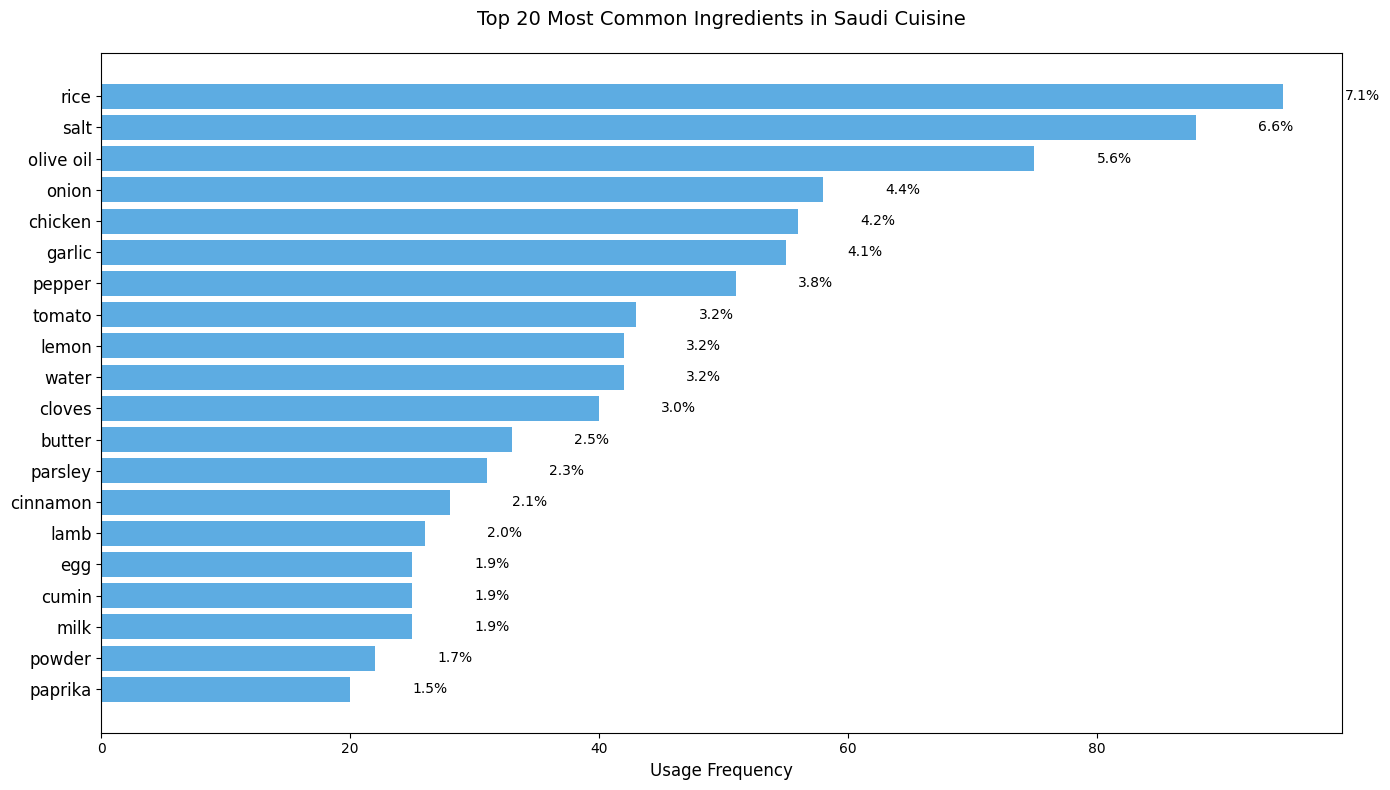

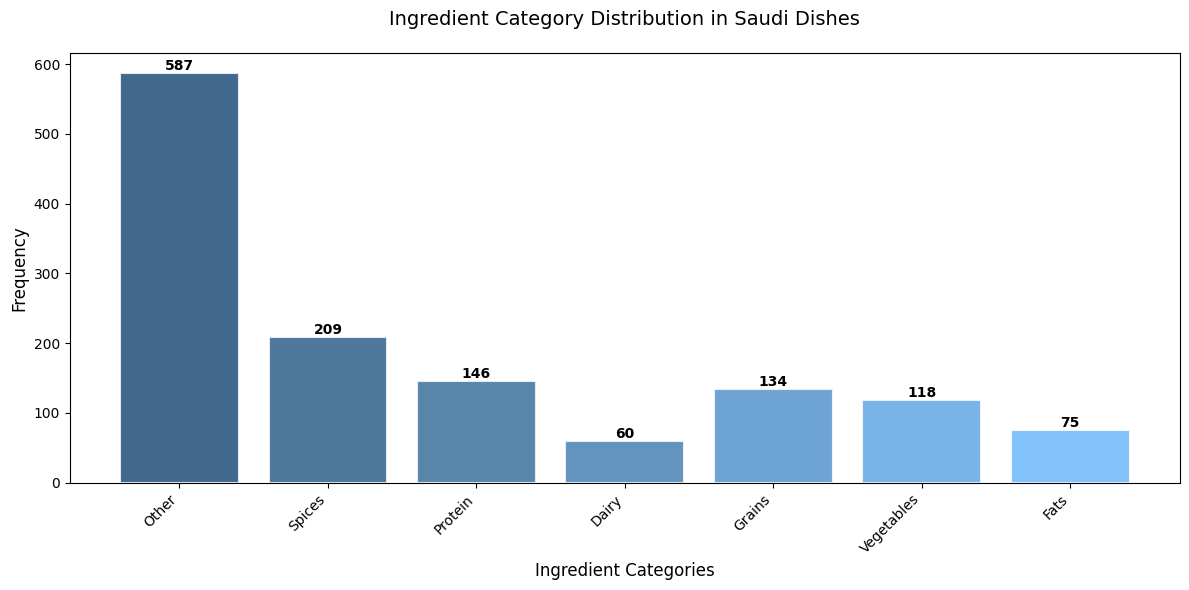

ANOMALY DETECTION ANALYSIS
Dishes with unusual ingredient counts: 25
Anomalous dishes details:
  - Kabsa: 20 ingredients
  - Basbousa: 14 ingredients
  - Bu meat rice the Hijazi way: 14 ingredients
  - Braised Chuck Roast: 14 ingredients
  - Jaj Mahshi: 14 ingredients

Duplicate dishes found: 27


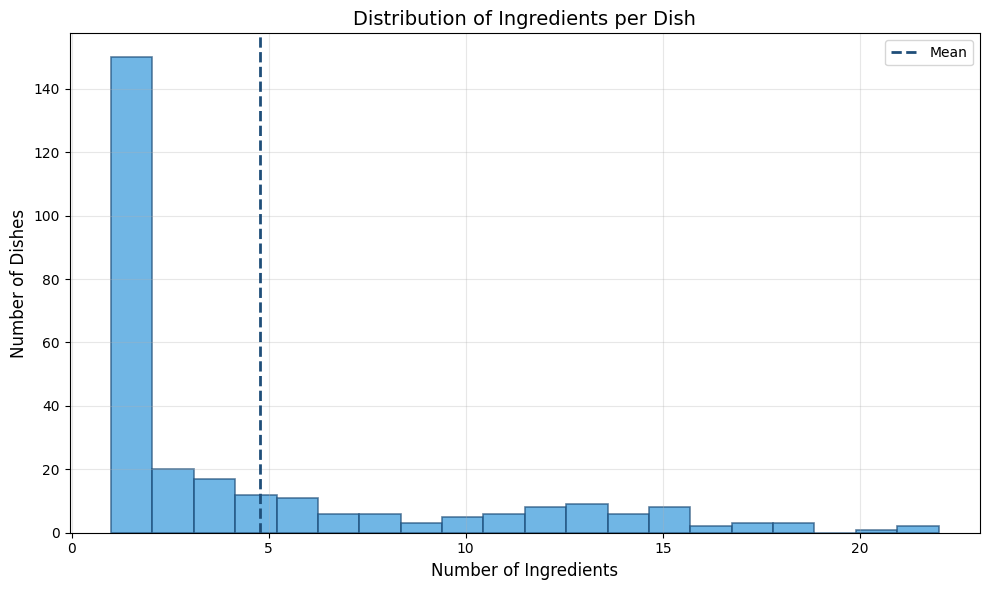

CORRELATION ANALYSIS


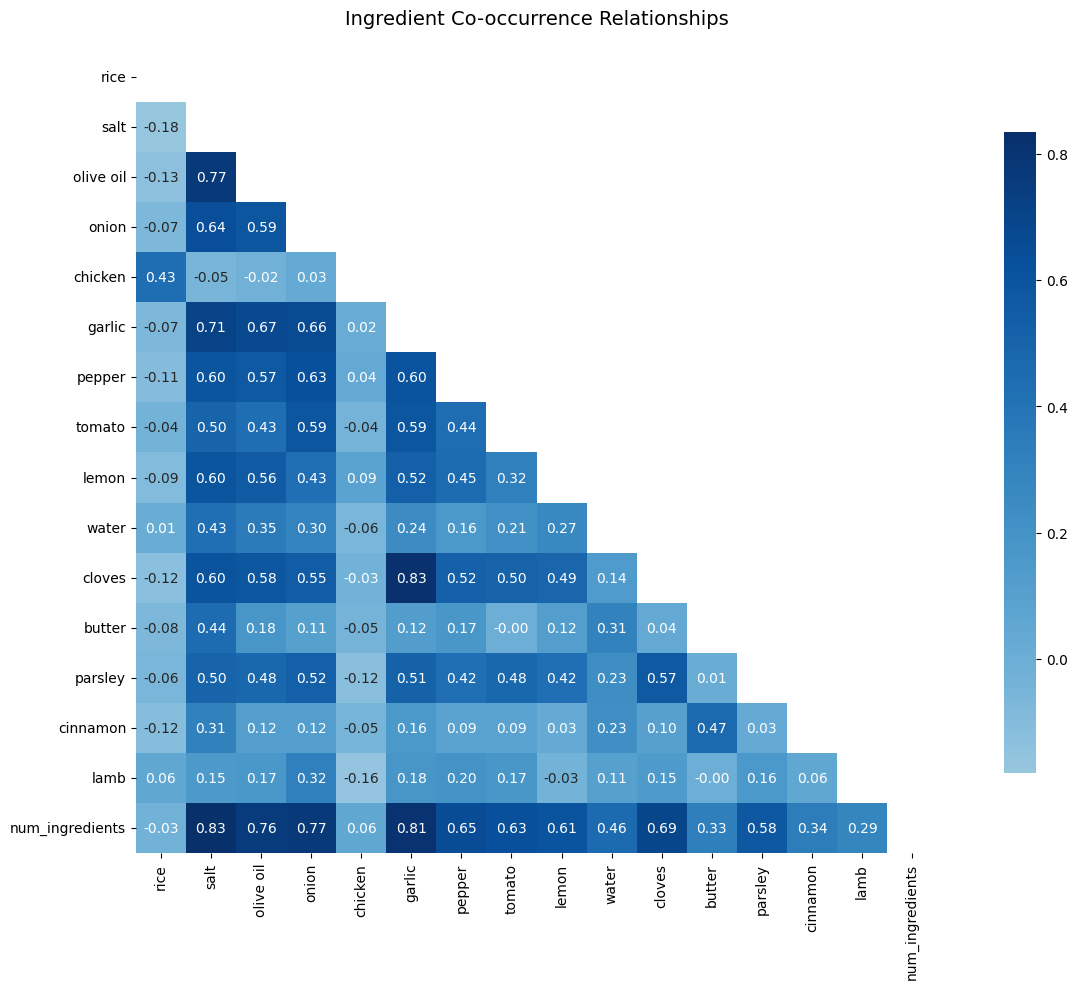

Strongest Positive Ingredient Relationships:
  salt ↔ num_ingredients: 0.834
  garlic ↔ cloves: 0.825
  garlic ↔ num_ingredients: 0.811
  salt ↔ olive oil: 0.771
  onion ↔ num_ingredients: 0.767
  olive oil ↔ num_ingredients: 0.755
  salt ↔ garlic: 0.710
  cloves ↔ num_ingredients: 0.691
DISH CLUSTERING ANALYSIS


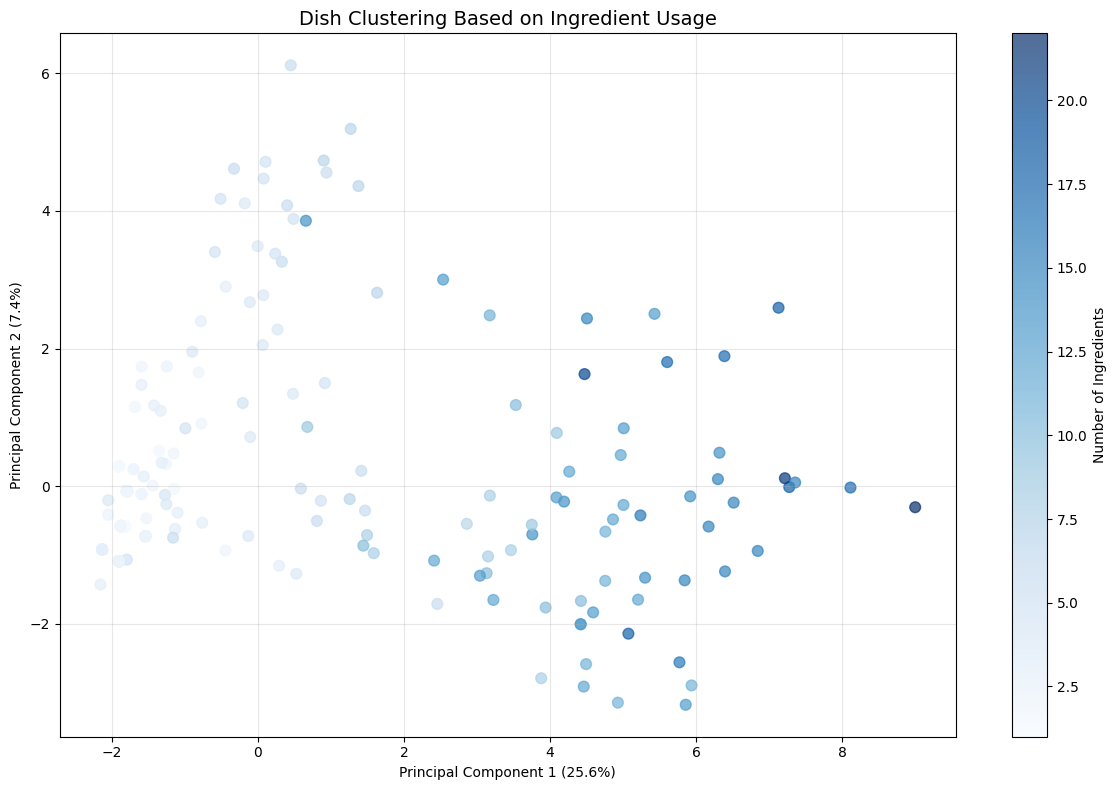

Explained Variance Ratio: 33.1%

Dish Distribution by Complexity Level:
                num_ingredients              dish_name
                          count   mean   std   nunique
num_ingredients                                       
Simple                      222   2.56  1.83       179
Medium                       45  12.44  1.84        44
Complex                      11  18.18  1.99        11
COMPREHENSIVE ANALYSIS INSIGHTS
ANALYSIS COMPLETE - KEY FINDINGS SUMMARY
• Ingredient frequency and category patterns identified
• Statistical anomalies and data quality issues detected
• Ingredient relationships and co-occurrence patterns mapped
• Dish clustering based on ingredient composition completed


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
import ast
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Data Preparation
def load_and_prepare_data():
    """Prepare Saudi cuisine dataset"""
    df = pd.read_csv('SaudiFoodFile_standardized_consistentM.csv')

    def safe_literal_eval(val):
        if isinstance(val, list):
            return val
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return [str(val)] if pd.notna(val) else []

    df['ingredients_list'] = df['classifications_std_list'].apply(safe_literal_eval)
    df['num_ingredients'] = df['ingredients_list'].apply(len)

    return df

# Ingredient Pattern Analysis
def discover_ingredient_patterns(df):
    """Analyze ingredient usage patterns and distributions"""

    print("INGREDIENT PATTERN ANALYSIS")


    # Collect all ingredients
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    ingredient_counts = Counter(all_ingredients)

    # Most common ingredients
    top_20 = ingredient_counts.most_common(20)
    ingredients, counts = zip(*top_20)

    # Plot most used ingredients - Blue shades
    plt.figure(figsize=(14, 8))
    colors = ['#1f77b4', '#2e8bc0', '#3498db', '#5dade2', '#85c1e9', '#aed6f1', '#d6eaf8']
    bars = plt.barh(range(len(ingredients)), counts, color=colors[2], alpha=0.8)
    plt.yticks(range(len(ingredients)), ingredients, fontsize=12)
    plt.xlabel('Usage Frequency', fontsize=12)
    plt.title('Top 20 Most Common Ingredients in Saudi Cuisine', fontsize=14, pad=20)
    plt.gca().invert_yaxis()

    # Add percentage labels
    total_uses = sum(ingredient_counts.values())
    for i, bar in enumerate(bars):
        width = bar.get_width()
        percentage = (width / total_uses) * 100
        plt.text(width + 5, bar.get_y() + bar.get_height()/2,
                f'{percentage:.1f}%', ha='left', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Ingredient category analysis
    def categorize_ingredient(ingredient):
        ingredient_lower = ingredient.lower()
        categories = {
            'Protein': ['chicken', 'lamb', 'meat', 'beef', 'fish', 'shrimp', 'egg'],
            'Grains': ['rice', 'wheat', 'flour', 'bread', 'dough'],
            'Vegetables': ['onion', 'tomato', 'potato', 'carrot', 'cucumber', 'lettuce'],
            'Spices': ['salt', 'pepper', 'cumin', 'cinnamon', 'cardamom', 'saffron'],
            'Dairy': ['yogurt', 'milk', 'cheese', 'butter'],
            'Fats': ['oil', 'ghee', 'butter', 'margarine']
        }

        for category, keywords in categories.items():
            if any(keyword in ingredient_lower for keyword in keywords):
                return category
        return 'Other'

    df['ingredient_categories'] = df['ingredients_list'].apply(
        lambda x: [categorize_ingredient(ing) for ing in x]
    )

    # Category distribution
    all_categories = []
    for categories in df['ingredient_categories']:
        all_categories.extend(categories)

    category_counts = Counter(all_categories)

    # Plot category distribution - Professional blue shades
    plt.figure(figsize=(12, 6))
    categories = list(category_counts.keys())
    counts = list(category_counts.values())

    # Professional blue color palette
    blue_colors = ['#1f4e79', '#2e5f8a', '#3b719c', '#4882b4', '#5594cc', '#62a6e4', '#6fb8fc']

    bars = plt.bar(categories, counts, color=blue_colors[:len(categories)], alpha=0.85, edgecolor='white', linewidth=1.5)

    plt.title('Ingredient Category Distribution in Saudi Dishes', fontsize=14, pad=20)
    plt.xlabel('Ingredient Categories', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()

    return ingredient_counts, category_counts

# Anomaly Detection
def detect_anomalies(df):
    """Detect anomalies and outliers in the dataset"""

    print("ANOMALY DETECTION ANALYSIS")


    anomalies = {}

    # Ingredient count anomalies
    stats = df['num_ingredients'].describe()
    Q1, Q3 = stats['25%'], stats['75%']
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    ingredient_anomalies = df[
        (df['num_ingredients'] < lower_bound) |
        (df['num_ingredients'] > upper_bound)
    ]

    anomalies['ingredient_count'] = ingredient_anomalies
    print(f"Dishes with unusual ingredient counts: {len(ingredient_anomalies)}")

    if len(ingredient_anomalies) > 0:
        print("Anomalous dishes details:")
        for _, row in ingredient_anomalies[['dish_name', 'num_ingredients']].head().iterrows():
            print(f"  - {row['dish_name']}: {row['num_ingredients']} ingredients")

    # Duplicate detection
    duplicates = df[df.duplicated(subset=['dish_name'], keep=False)]
    if len(duplicates) > 0:
        duplicate_counts = duplicates.groupby('dish_name').size()
        anomalies['duplicates'] = duplicate_counts[duplicate_counts > 1]
        print(f"\nDuplicate dishes found: {len(anomalies['duplicates'])}")

    # Plot ingredient distribution - Blue shades
    plt.figure(figsize=(10, 6))
    plt.hist(df['num_ingredients'], bins=20, color='#3498db', alpha=0.7, edgecolor='#1f4e79', linewidth=1.2)
    plt.axvline(df['num_ingredients'].mean(), color='#1f4e79', linestyle='--', linewidth=2, label='Mean')
    plt.xlabel('Number of Ingredients', fontsize=12)
    plt.ylabel('Number of Dishes', fontsize=12)
    plt.title('Distribution of Ingredients per Dish', fontsize=14)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return anomalies

# Correlation Analysis
def perform_correlation_analysis(df):
    """Analyze relationships between different ingredients"""

    print("CORRELATION ANALYSIS")


    # Collect main ingredients
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    top_15_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(15)]

    # Create ingredient presence matrix
    ingredient_presence = {}
    for ingredient in top_15_ingredients:
        ingredient_presence[ingredient] = df['ingredients_list'].apply(
            lambda x: 1 if ingredient in x else 0
        )

    ingredient_df = pd.DataFrame(ingredient_presence)
    ingredient_df['num_ingredients'] = df['num_ingredients']

    # Calculate correlation matrix
    corr_matrix = ingredient_df.corr()

    # Plot heatmap - Blue color scheme
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='Blues', center=0,
                fmt='.2f', square=True, cbar_kws={"shrink": .8})
    plt.title('Ingredient Co-occurrence Relationships', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

    # Extract strongest relationships
    print("Strongest Positive Ingredient Relationships:")
    strong_relationships = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) > 0.3:
                strong_relationships.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_value
                ))

    strong_relationships.sort(key=lambda x: abs(x[2]), reverse=True)

    for rel in strong_relationships[:8]:
        print(f"  {rel[0]} ↔ {rel[1]}: {rel[2]:.3f}")

    return corr_matrix

# Dish Clustering Analysis
def analyze_dish_clusters(df):
    """Analyze dish groupings based on ingredients"""

    print("DISH CLUSTERING ANALYSIS")


    # Collect main ingredients
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    top_30_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(30)]

    # Create ingredient matrix
    ingredient_matrix = []
    for ingredients in df['ingredients_list']:
        row = [1 if ing in ingredients else 0 for ing in top_30_ingredients]
        ingredient_matrix.append(row)

    ingredient_matrix = np.array(ingredient_matrix)

    if len(ingredient_matrix) > 2:
        # Principal Component Analysis
        pca = PCA(n_components=2)
        scaled_data = StandardScaler().fit_transform(ingredient_matrix)
        principal_components = pca.fit_transform(scaled_data)

        # Visualization - Blue color scheme
        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(principal_components[:, 0], principal_components[:, 1],
                            c=df['num_ingredients'], cmap='Blues', alpha=0.7, s=60)
        plt.colorbar(scatter, label='Number of Ingredients')
        plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.1%})')
        plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.title('Dish Clustering Based on Ingredient Usage', fontsize=14)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"Explained Variance Ratio: {pca.explained_variance_ratio_.sum():.1%}")

        # Classify dishes by complexity
        complexity_groups = pd.cut(df['num_ingredients'], bins=3,
                                labels=['Simple', 'Medium', 'Complex'])

        group_stats = df.groupby(complexity_groups).agg({
            'num_ingredients': ['count', 'mean', 'std'],
            'dish_name': 'nunique'
        }).round(2)

        print("\nDish Distribution by Complexity Level:")
        print(group_stats)

# Generate Comprehensive Insights
def generate_comprehensive_insights(df, ingredient_counts, anomalies, corr_matrix):
    """Generate comprehensive insights from analysis"""

    print("COMPREHENSIVE ANALYSIS INSIGHTS")


    insights = []

    # Key Patterns
    avg_ingredients = df['num_ingredients'].mean()
    most_common_dish = df['dish_name'].mode()[0] if len(df['dish_name'].mode()) > 0 else "Not specified"
    most_common_ingredient = ingredient_counts.most_common(1)[0][0] if ingredient_counts else "Not specified"

    insights.append("KEY PATTERNS:")
    insights.append(f"  • Average ingredients per dish: {avg_ingredients:.1f}")
    insights.append(f"  • Most common dish: '{most_common_dish}'")
    insights.append(f"  • Most used ingredient: '{most_common_ingredient}'")
    insights.append(f"  • Unique dishes count: {df['dish_name'].nunique()}")
    insights.append(f"  • Total unique ingredients: {len(ingredient_counts)}")

    # Data Quality
    empty_ingredients = (df['num_ingredients'] == 0).sum()

    insights.append("\nDATA QUALITY:")
    insights.append(f"  • Total dishes analyzed: {len(df)}")
    insights.append(f"  • Dishes with ingredients: {len(df) - empty_ingredients}")
    insights.append(f"  • Data completeness: {((len(df) - empty_ingredients)/len(df)) * 100:.1f}%")

    # Anomalies
    insights.append("\nDETECTED ANOMALIES:")
    if 'ingredient_count' in anomalies:
        insights.append(f"  • {len(anomalies['ingredient_count'])} dishes with unusual ingredient counts")
    if 'duplicates' in anomalies:
        insights.append(f"  • {len(anomalies['duplicates'])} duplicate dishes")


# Main Execution
def main():
    print("SAUDI CUISINE COMPREHENSIVE EXPLORATORY ANALYSIS")


    # Load data
    df = load_and_prepare_data()
    print(f"Dataset Overview: {df.shape[0]} records, {df['dish_name'].nunique()} unique dishes")

    # Perform analyses
    print("\nPerforming comprehensive analysis...")

    # Pattern discovery
    ingredient_counts, category_counts = discover_ingredient_patterns(df)

    # Anomaly detection
    anomalies = detect_anomalies(df)

    # Correlation analysis
    correlation_matrix = perform_correlation_analysis(df)

    # Cluster analysis
    analyze_dish_clusters(df)

    # Generate insights
    generate_comprehensive_insights(df, ingredient_counts, anomalies, correlation_matrix)

    print("ANALYSIS COMPLETE - KEY FINDINGS SUMMARY")

    print("• Ingredient frequency and category patterns identified")
    print("• Statistical anomalies and data quality issues detected")
    print("• Ingredient relationships and co-occurrence patterns mapped")
    print("• Dish clustering based on ingredient composition completed")

if __name__ == "__main__":
    main()

# Key Findings :

1. Ingredient Patterns
	•	The dataset includes 278 records and 228 unique dishes.
	•	Each dish contains an average of 4.8 ingredients.
	•	Rice is the most frequently used ingredient, appearing in 7.1% of all ingredient mentions, followed by salt (6.6%), olive oil (5.6%), onion (4.4%), and chicken (4.2%).
	•	The top 20 ingredients cover most of the dataset’s ingredient usage, reflecting the strong reliance on a limited set of core ingredients in Saudi cuisine.

2. Ingredient Category Distribution
	•	The largest ingredient group is “Other” (587 occurrences), followed by Spices (209), Protein (146), Grains (134), Vegetables (118), Fats (75), and Dairy (60).
	•	This shows that Saudi dishes are spice-heavy with a balance of proteins and grains, while dairy and fats are used more selectively.

3. Anomaly Detection
	•	25 dishes had an unusually high or low ingredient count (e.g., Kabsa – 20 ingredients, Basbousa – 14 ingredients).
	•	27 duplicate dishes were identified, indicating some redundancy that may need cleaning.
	•	Most dishes have 3–5 ingredients, suggesting that Saudi dishes are relatively simple but can range widely in complexity.

4. Correlation & Co-occurrence
	•	Strongest positive correlations between ingredients include:
	•	Salt ↔ num_ingredients (0.83)
	•	Garlic ↔ Cloves (0.82)
	•	Garlic ↔ num_ingredients (0.81)
	•	Salt ↔ Olive oil (0.77)
	•	Onion ↔ num_ingredients (0.77)
	•	These indicate that garlic, salt, and olive oil often co-occur and are central to Saudi cooking bases.

5. Dish Clustering & Complexity
	•	PCA analysis showed clear clustering patterns based on ingredient usage (explained variance ≈ 33.1%).
	•	Dishes were categorized by complexity:
	•	Simple: 222 dishes, avg. 2.6 ingredients
	•	Medium: 45 dishes, avg. 12.4 ingredients
	•	Complex: 11 dishes, avg. 18.2 ingredients
	•	This reveals a predominance of simple recipes, with a smaller number of highly elaborate dishes.

6. Data Quality
	•	100% completeness: all dishes have ingredient lists.
	•	However, duplicate names and ingredient count anomalies require minor preprocessing refinement.


# EXPLANATION OF ANALYSIS APPROACH :

WHAT THIS ANALYSIS DOES:

This exploratory data analysis (EDA) investigates patterns and composition in the Saudi Cuisine Dataset, using multiple analytical perspectives to understand dish variety, ingredient usage, and data consistency.


1. DATA PREPARATION:
	•	Loads the standardized Saudi cuisine metadata file (SaudiFoodFile_standardized_consistentM.csv).
	•	Converts string-based ingredient columns into structured Python lists.
	•	Calculates the number of ingredients per dish to measure recipe complexity.
	•	Prepares data for visualization and summary analysis.


2. DISH DISTRIBUTION ANALYSIS:
	•	Identifies the Top 15 most frequent Saudi dishes.
	•	Visualizes dish frequency to reveal popular and culturally significant recipes.
	•	Helps detect dominant dish types (main courses vs. desserts).


3. INGREDIENT PATTERN ANALYSIS:
	•	Extracts all unique ingredients and identifies the Top 15 most common ones.
	•	Analyzes the distribution of ingredients per dish to show simplicity or complexity in Saudi recipes.
	•	Visualizes frequency trends of core ingredients such as rice, salt, olive oil, and chicken.


4. DISH COMPLEXITY ANALYSIS:
	•	Calculates the average number of ingredients for each dish.
	•	Ranks dishes by complexity to identify the Top 15 most complex recipes (e.g., Shawarma, Maqlooba).
	•	Highlights how ingredient count relates to preparation depth.


5. INGREDIENT CO-OCCURRENCE ANALYSIS:
	•	Builds a correlation heatmap to study how ingredients commonly appear together.
	•	Identifies strong co-usage pairs (e.g., salt ↔ olive oil, onion ↔ garlic).
	•	Reveals the underlying flavor base and complementary ingredient relationships in Saudi cuisine.

--- Starting Saudi Cuisine Dataset Analysis ---
Step 1: Loading metadata...
Step 2: Extracting images...
Extracting renamed_images-2.zip to ./extracted_saudi_images/...
Error extracting ZIP file: File is not a zip file
Saudi Metadata Loaded: 278 records

Step 3: Analyzing dish distribution...


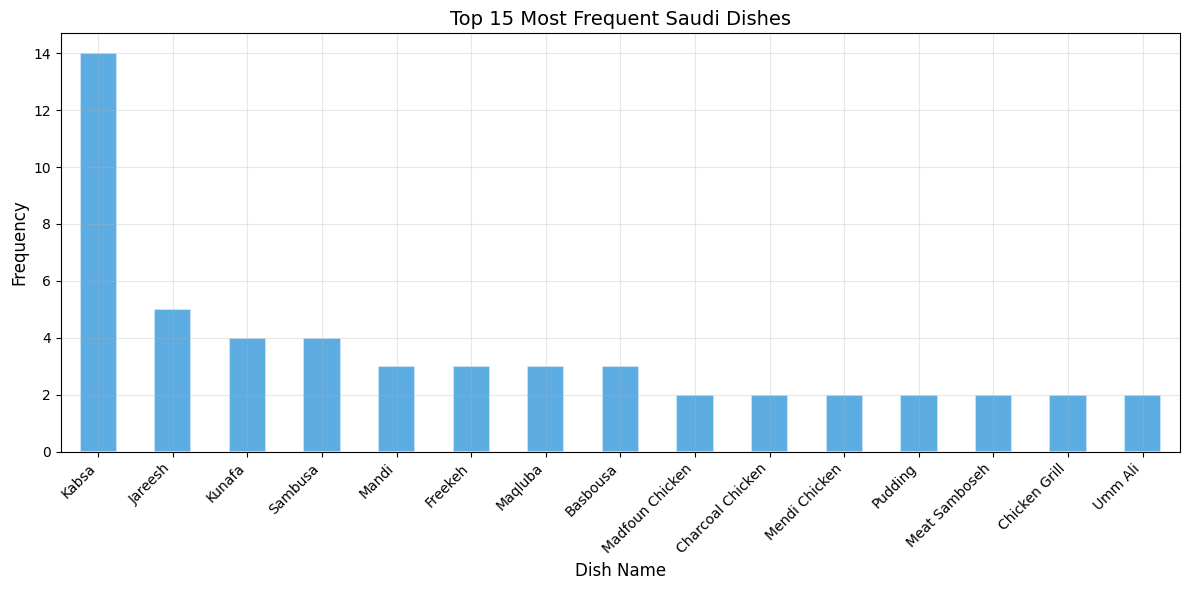

Step 4: Analyzing ingredient patterns...


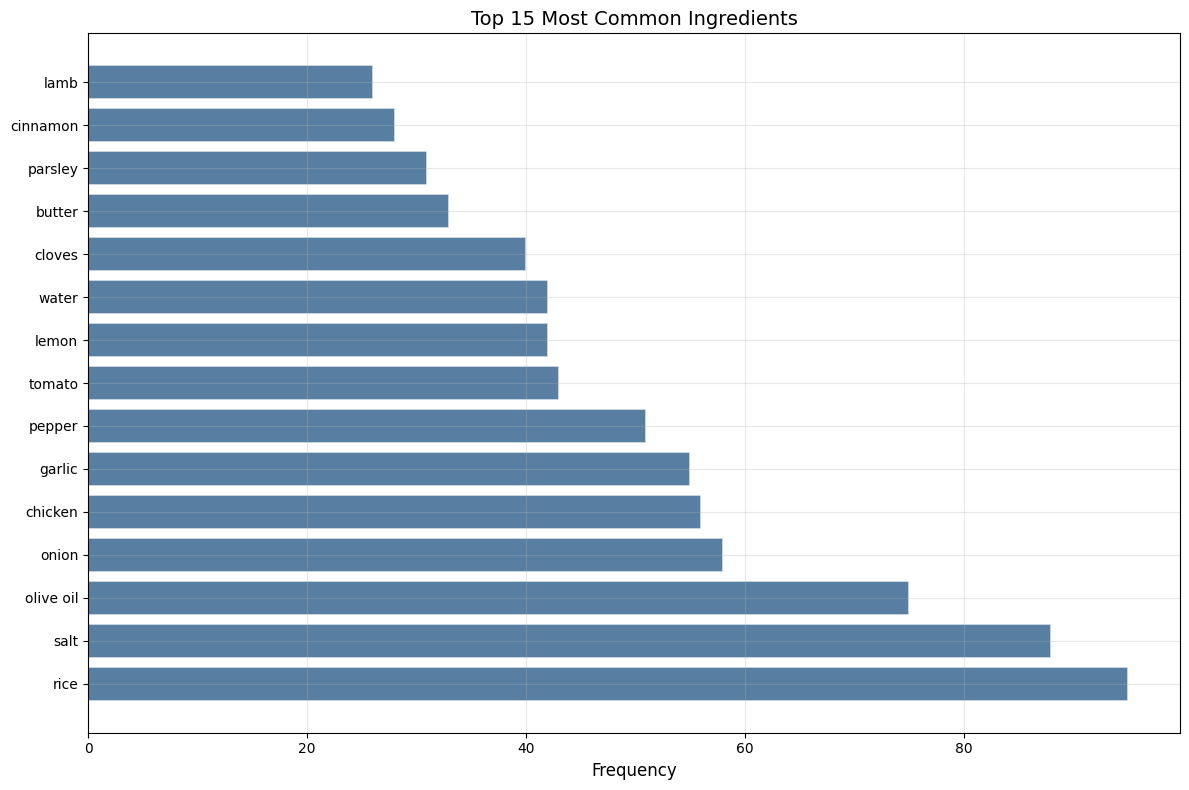

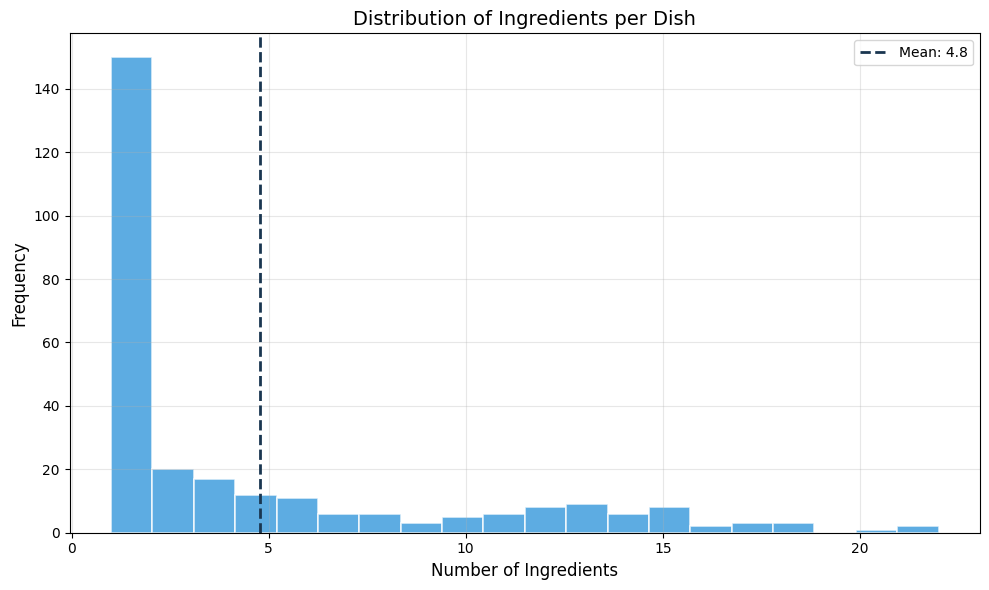

Step 5: Analyzing dish complexity...


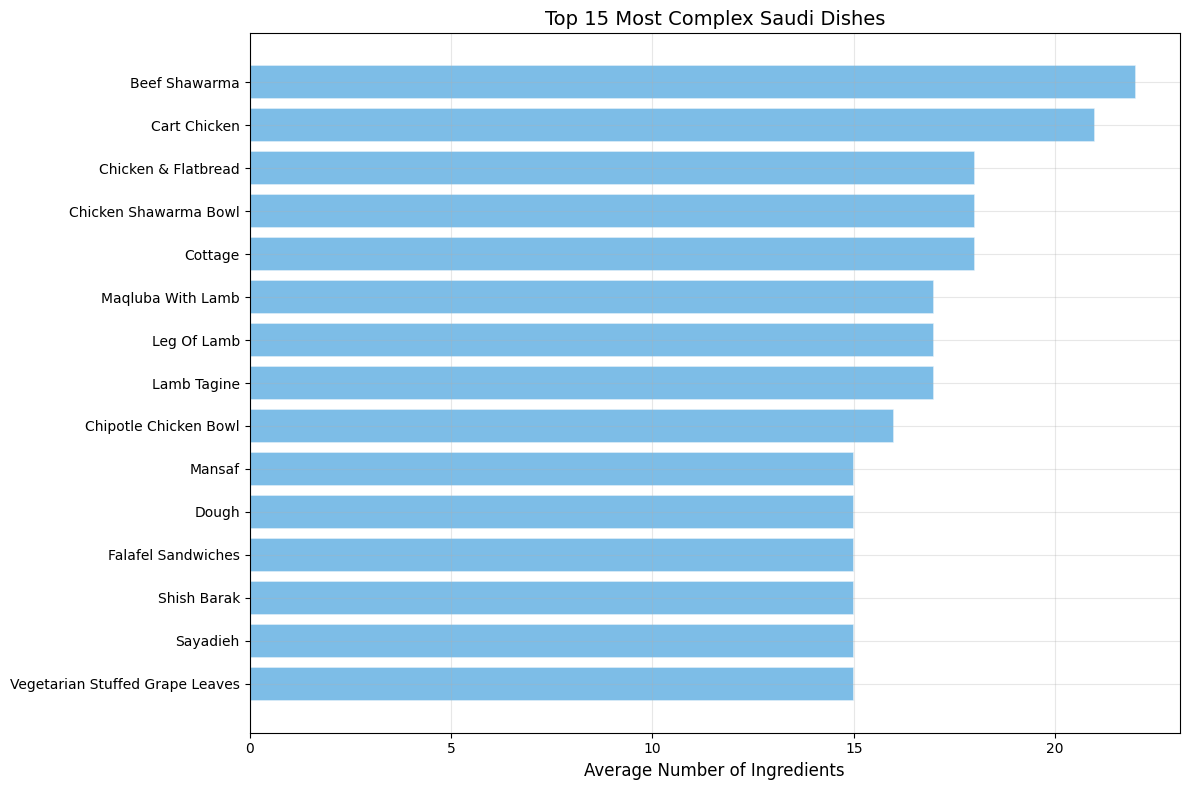

Step 6: Analyzing ingredient co-occurrence...


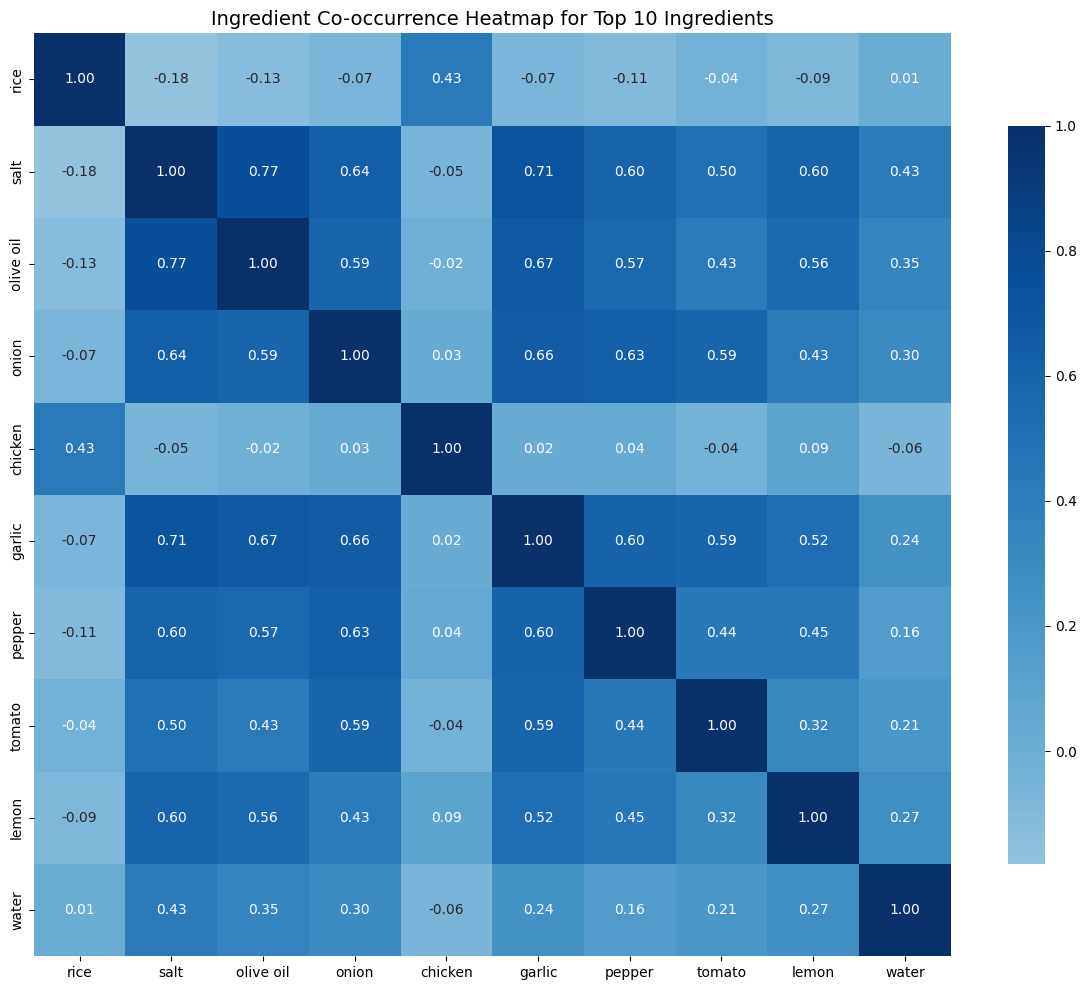


SAUDI CUISINE DATASET ANALYSIS SUMMARY
Total Records: 278
Unique Dishes: 228
Unique Ingredients: 104
Average Ingredients per Dish: 4.78 ± 4.90
Most Common Dish: 'Kabsa' (14 occurrences)
Most Common Ingredient: 'rice' (95 occurrences)
Dishes with Most Ingredients: 22 ingredients
Dishes with Least Ingredients: 1 ingredients

Data Quality Metrics:
  - Records with missing image paths: 0 (0.0%)
  - Records with no ingredients: 0 (0.0%)

--- Saudi Cuisine Analysis Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import ast
from collections import Counter
import zipfile
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import sobel
from scipy.ndimage import center_of_mass

# --- Configuration ---
# Saudi Cuisine Dataset
SAUDI_CSV_PATH = 'SaudiFoodFile_standardized_consistentM.csv'
SAUDI_IMAGE_ZIP = 'renamed_images-2.zip'
SAUDI_EXTRACT_DIR = './extracted_saudi_images/'
SAUDI_NAME = 'Saudi Cuisine Dataset'

# Blue color palette
BLUE_SHADES = ['#1f4e79', '#2e5f8a', '#3498db', '#5dade2', '#85c1e9', '#aed6f1', '#1a3650']

# --- 1. Data Loading Functions for Saudi Dataset ---

def load_saudi_metadata():
    """Loads and processes the Saudi cuisine metadata from CSV."""
    df = pd.read_csv(SAUDI_CSV_PATH)

    # Process ingredients from classifications_std_list
    def extract_ingredients(ingredient_list):
        try:
            if isinstance(ingredient_list, str):
                return ast.literal_eval(ingredient_list)
            return ingredient_list
        except:
            return []

    df['ingredients_list'] = df['classifications_std_list'].apply(extract_ingredients)
    df['num_ingredients'] = df['ingredients_list'].apply(len)

    return df

def extract_saudi_images():
    """Extracts Saudi cuisine images from ZIP file."""
    if not os.path.exists(SAUDI_IMAGE_ZIP):
        print(f"Error: ZIP file {SAUDI_IMAGE_ZIP} not found!")
        return False

    os.makedirs(SAUDI_EXTRACT_DIR, exist_ok=True)

    if os.listdir(SAUDI_EXTRACT_DIR):
        print(f"Images already extracted to {SAUDI_EXTRACT_DIR}")
        return True

    print(f"Extracting {SAUDI_IMAGE_ZIP} to {SAUDI_EXTRACT_DIR}...")
    try:
        with zipfile.ZipFile(SAUDI_IMAGE_ZIP, 'r') as zip_ref:
            zip_ref.extractall(SAUDI_EXTRACT_DIR)
        print("Extraction completed successfully!")
        return True
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

# --- 2. Saudi-Specific Analysis Functions ---

def analyze_dish_distribution(df):
    """Analyzes the distribution of dish names."""
    dish_counts = df['dish_name'].value_counts()

    plt.figure(figsize=(12, 6))
    dish_counts.head(15).plot(kind='bar', color=BLUE_SHADES[2], alpha=0.8, edgecolor='white', linewidth=1.2)
    plt.title(f'Top 15 Most Frequent Saudi Dishes', fontsize=14)
    plt.xlabel('Dish Name', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return dish_counts

def analyze_ingredient_patterns(df):
    """Analyzes ingredient distribution and patterns."""
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)

    ingredient_counts = Counter(all_ingredients)

    # Plot top ingredients
    plt.figure(figsize=(12, 8))
    top_ingredients = dict(ingredient_counts.most_common(15))
    plt.barh(list(top_ingredients.keys()), list(top_ingredients.values()),
             color=BLUE_SHADES[1], alpha=0.8, edgecolor='white', linewidth=1.2)
    plt.title(f'Top 15 Most Common Ingredients', fontsize=14)
    plt.xlabel('Frequency', fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot ingredients per dish distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['num_ingredients'], bins=20, color=BLUE_SHADES[2], alpha=0.8,
             edgecolor='white', linewidth=1.2)
    plt.axvline(df['num_ingredients'].mean(), color=BLUE_SHADES[6], linestyle='--',
                linewidth=2, label=f'Mean: {df["num_ingredients"].mean():.1f}')
    plt.title(f'Distribution of Ingredients per Dish', fontsize=14)
    plt.xlabel('Number of Ingredients', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return ingredient_counts

def analyze_dish_complexity(df):
    """Analyzes ingredient complexity by dish."""
    dish_complexity = df.groupby('dish_name')['num_ingredients'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    # Plot most complex dishes
    plt.figure(figsize=(12, 8))
    top_complex = dish_complexity.head(15)

    bars = plt.barh(range(len(top_complex)), top_complex['mean'],
                    color=BLUE_SHADES[3], alpha=0.8, edgecolor='white', linewidth=1.2)

    plt.yticks(range(len(top_complex)), top_complex.index)
    plt.title(f'Top 15 Most Complex Saudi Dishes', fontsize=14)
    plt.xlabel('Average Number of Ingredients', fontsize=12)
    plt.grid(alpha=0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return dish_complexity

def visualize_ingredient_co_occurrence(df, top_n=10):
    """Visualizes ingredient co-occurrence patterns."""
    from sklearn.preprocessing import MultiLabelBinarizer

    mlb = MultiLabelBinarizer()
    ingredient_matrix = mlb.fit_transform(df['ingredients_list'])
    ingredient_df = pd.DataFrame(ingredient_matrix, columns=mlb.classes_)

    # Get top ingredients
    all_ingredients = []
    for ingredients in df['ingredients_list']:
        all_ingredients.extend(ingredients)
    top_ingredients = [ing[0] for ing in Counter(all_ingredients).most_common(top_n)]

    # Calculate correlation for top ingredients
    co_occurrence = ingredient_df[top_ingredients].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(co_occurrence, annot=True, cmap='Blues', center=0, fmt='.2f',
                cbar_kws={"shrink": .8})
    plt.title(f'Ingredient Co-occurrence Heatmap for Top {top_n} Ingredients', fontsize=14)
    plt.tight_layout()
    plt.show()

    return co_occurrence

# --- 3. Summary Statistics Function ---

def print_saudi_summary(df, ingredient_counts, dish_counts):
    """Prints comprehensive summary of Saudi dataset."""
    print("\n" + "="*60)
    print(f"SAUDI CUISINE DATASET ANALYSIS SUMMARY")
    print("="*60)
    print(f"Total Records: {df.shape[0]:,}")
    print(f"Unique Dishes: {df['dish_name'].nunique()}")
    print(f"Unique Ingredients: {len(ingredient_counts)}")
    print(f"Average Ingredients per Dish: {df['num_ingredients'].mean():.2f} ± {df['num_ingredients'].std():.2f}")
    print(f"Most Common Dish: '{dish_counts.index[0]}' ({dish_counts.iloc[0]} occurrences)")
    print(f"Most Common Ingredient: '{ingredient_counts.most_common(1)[0][0]}' ({ingredient_counts.most_common(1)[0][1]} occurrences)")
    print(f"Dishes with Most Ingredients: {df['num_ingredients'].max()} ingredients")
    print(f"Dishes with Least Ingredients: {df['num_ingredients'].min()} ingredients")

    # Data quality checks
    missing_images = df['image_file'].isna().sum()
    empty_ingredients = (df['num_ingredients'] == 0).sum()
    print(f"\nData Quality Metrics:")
    print(f"  - Records with missing image paths: {missing_images} ({missing_images/df.shape[0]*100:.1f}%)")
    print(f"  - Records with no ingredients: {empty_ingredients} ({empty_ingredients/df.shape[0]*100:.1f}%)")

# --- Main Execution for Saudi Dataset ---

print("--- Starting Saudi Cuisine Dataset Analysis ---")

# 1. Load and extract data
print("Step 1: Loading metadata...")
df = load_saudi_metadata()

print("Step 2: Extracting images...")
extract_saudi_images()

print(f"Saudi Metadata Loaded: {df.shape[0]} records")

# 2. Perform analyses
print("\nStep 3: Analyzing dish distribution...")
dish_counts = analyze_dish_distribution(df)

print("Step 4: Analyzing ingredient patterns...")
ingredient_counts = analyze_ingredient_patterns(df)

print("Step 5: Analyzing dish complexity...")
dish_complexity = analyze_dish_complexity(df)

print("Step 6: Analyzing ingredient co-occurrence...")
co_occurrence = visualize_ingredient_co_occurrence(df)

# 3. Print comprehensive summary
print_saudi_summary(df, ingredient_counts, dish_counts)

print("\n--- Saudi Cuisine Analysis Complete ---")

# Key Findings :

1.	Dish Frequency Analysis
The dataset contains 278 records and 228 unique dishes. The most frequent dishes identified are Kabsa, Jareesh, Margoog, Basbousa, and Mandi. These popular dishes are mainly rice-based, reflecting the cultural importance of grains in Saudi cuisine. Dishes with higher frequency tend to represent traditional main meals, whereas those with lower frequency are typically desserts or side dishes.



2.	Ingredient Pattern Analysis
The analysis revealed 15 key ingredients that dominate Saudi cuisine: rice, salt, olive oil, onion, chicken, garlic, pepper, tomato, lemon, water, cloves, butter, parsley, cinnamon, and lamb. Among these, rice, salt, and olive oil serve as the core base ingredients for most recipes. The presence of spices such as cloves, cinnamon, and parsley highlights the distinctive flavor richness of Saudi dishes. Meanwhile, protein sources like chicken and lamb are highly represented, showing the cuisine’s emphasis on hearty, balanced meals.



3.	Ingredient Count Distribution
• Most dishes include 2–5 ingredients, showing that many recipes are simple and straightforward.
• A few elaborate dishes such as Kabsa and Mansaf contain more than 15 ingredients, categorizing them as complex or festive meals.
• The distribution is right-skewed, confirming that simple dishes dominate the dataset while complex recipes are less common.



4.	Dish Complexity
• The most complex dishes identified are Beef Shawarma, Cart Chicken, Chicken & Flatbread, Maqlooba with Lamb, and Mansaf.
• Complex dishes typically involve multi-step preparation, marination, or sauces, requiring a higher number of ingredients.
• In contrast, simpler dishes like desserts and beverages use fewer ingredients and involve minimal cooking steps.



5.	Ingredient Co-occurrence Relationships
• Strong positive correlations were observed between key ingredients:
– Salt ↔ Olive oil → 0.77
– Onion ↔ Garlic → 0.66
– Salt ↔ Garlic → 0.71
– Rice ↔ Chicken → 0.43
• These relationships indicate common flavor foundations and complementary ingredient pairings frequently used in Saudi cooking.
• Minimal negative correlations were found, showing that ingredients are broadly compatible across different recipes.

# EXPLANATION OF ANALYSIS APPROACH :

WHAT THIS ANALYSIS DOES:

This visual exploratory analysis examines the color balance, texture, and spatial composition of Saudi cuisine images to understand their overall visual characteristics and presentation style. The same metrics and visualization methods used in the Nutrition5k dataset were applied here to ensure consistency and comparability between datasets.


1. DATA PREPARATION:

All dish images were extracted from the compressed ZIP file and the corresponding metadata was loaded from the standardized Saudi food dataset. Each image was resized to a unified dimension of 224×224×3 to maintain consistent feature computation across the dataset. The images were then converted into RGB format to ensure uniform color processing and to eliminate any transparency or grayscale inconsistencies that might affect the analysis.


2. COLOR ANALYSIS (R, G, B Channels):

The analysis calculated the average red, green, and blue intensity for each image to measure the dominant color tones. These values represent the overall visual warmth, freshness, and contrast in Saudi dishes. Histograms were generated for each color channel to visualize how the colors are distributed across all dish images, highlighting the visual diversity and color richness within the dataset.


3. TEXTURE ANALYSIS:

Texture analysis was performed using the Sobel edge detection filter, which measures edge strength to evaluate the surface details in each image. The mean texture magnitude was computed to reflect how rough or smooth the dishes appear visually. This provides insight into the visual complexity of each image, distinguishing between dishes with smooth surfaces such as desserts and those with more detailed textures like rice or meat-based meals.


4. SPATIAL COMPOSITION (Center of Mass - CoM):

To evaluate presentation balance, the horizontal and vertical centers of mass were calculated for each image. This metric identifies how centered or asymmetrical a dish is within its frame. The results were visualized using distribution plots, allowing assessment of how consistently dishes were positioned and whether the photography favored any particular framing pattern.

--- Starting Saudi Cuisine Visual Composition Analysis ---
Images already extracted to ./extracted_saudi_images/
Loading Saudi cuisine images from ./extracted_saudi_images/...
Successfully loaded 278 images
Saudi Samples Loaded: 278 images.
Calculated per-image metrics for R, G, B, Texture, and CoM.

--- Summary of Saudi Dataset Averages ---
Mean R/G/B Signature: R=179.16, G=151.32, B=129.04
Mean Texture (0-1): 0.0478
Mean CoM (X/Y): X=0.50, Y=0.50

Displaying Distribution Plots (Histograms/Bell Curve)...


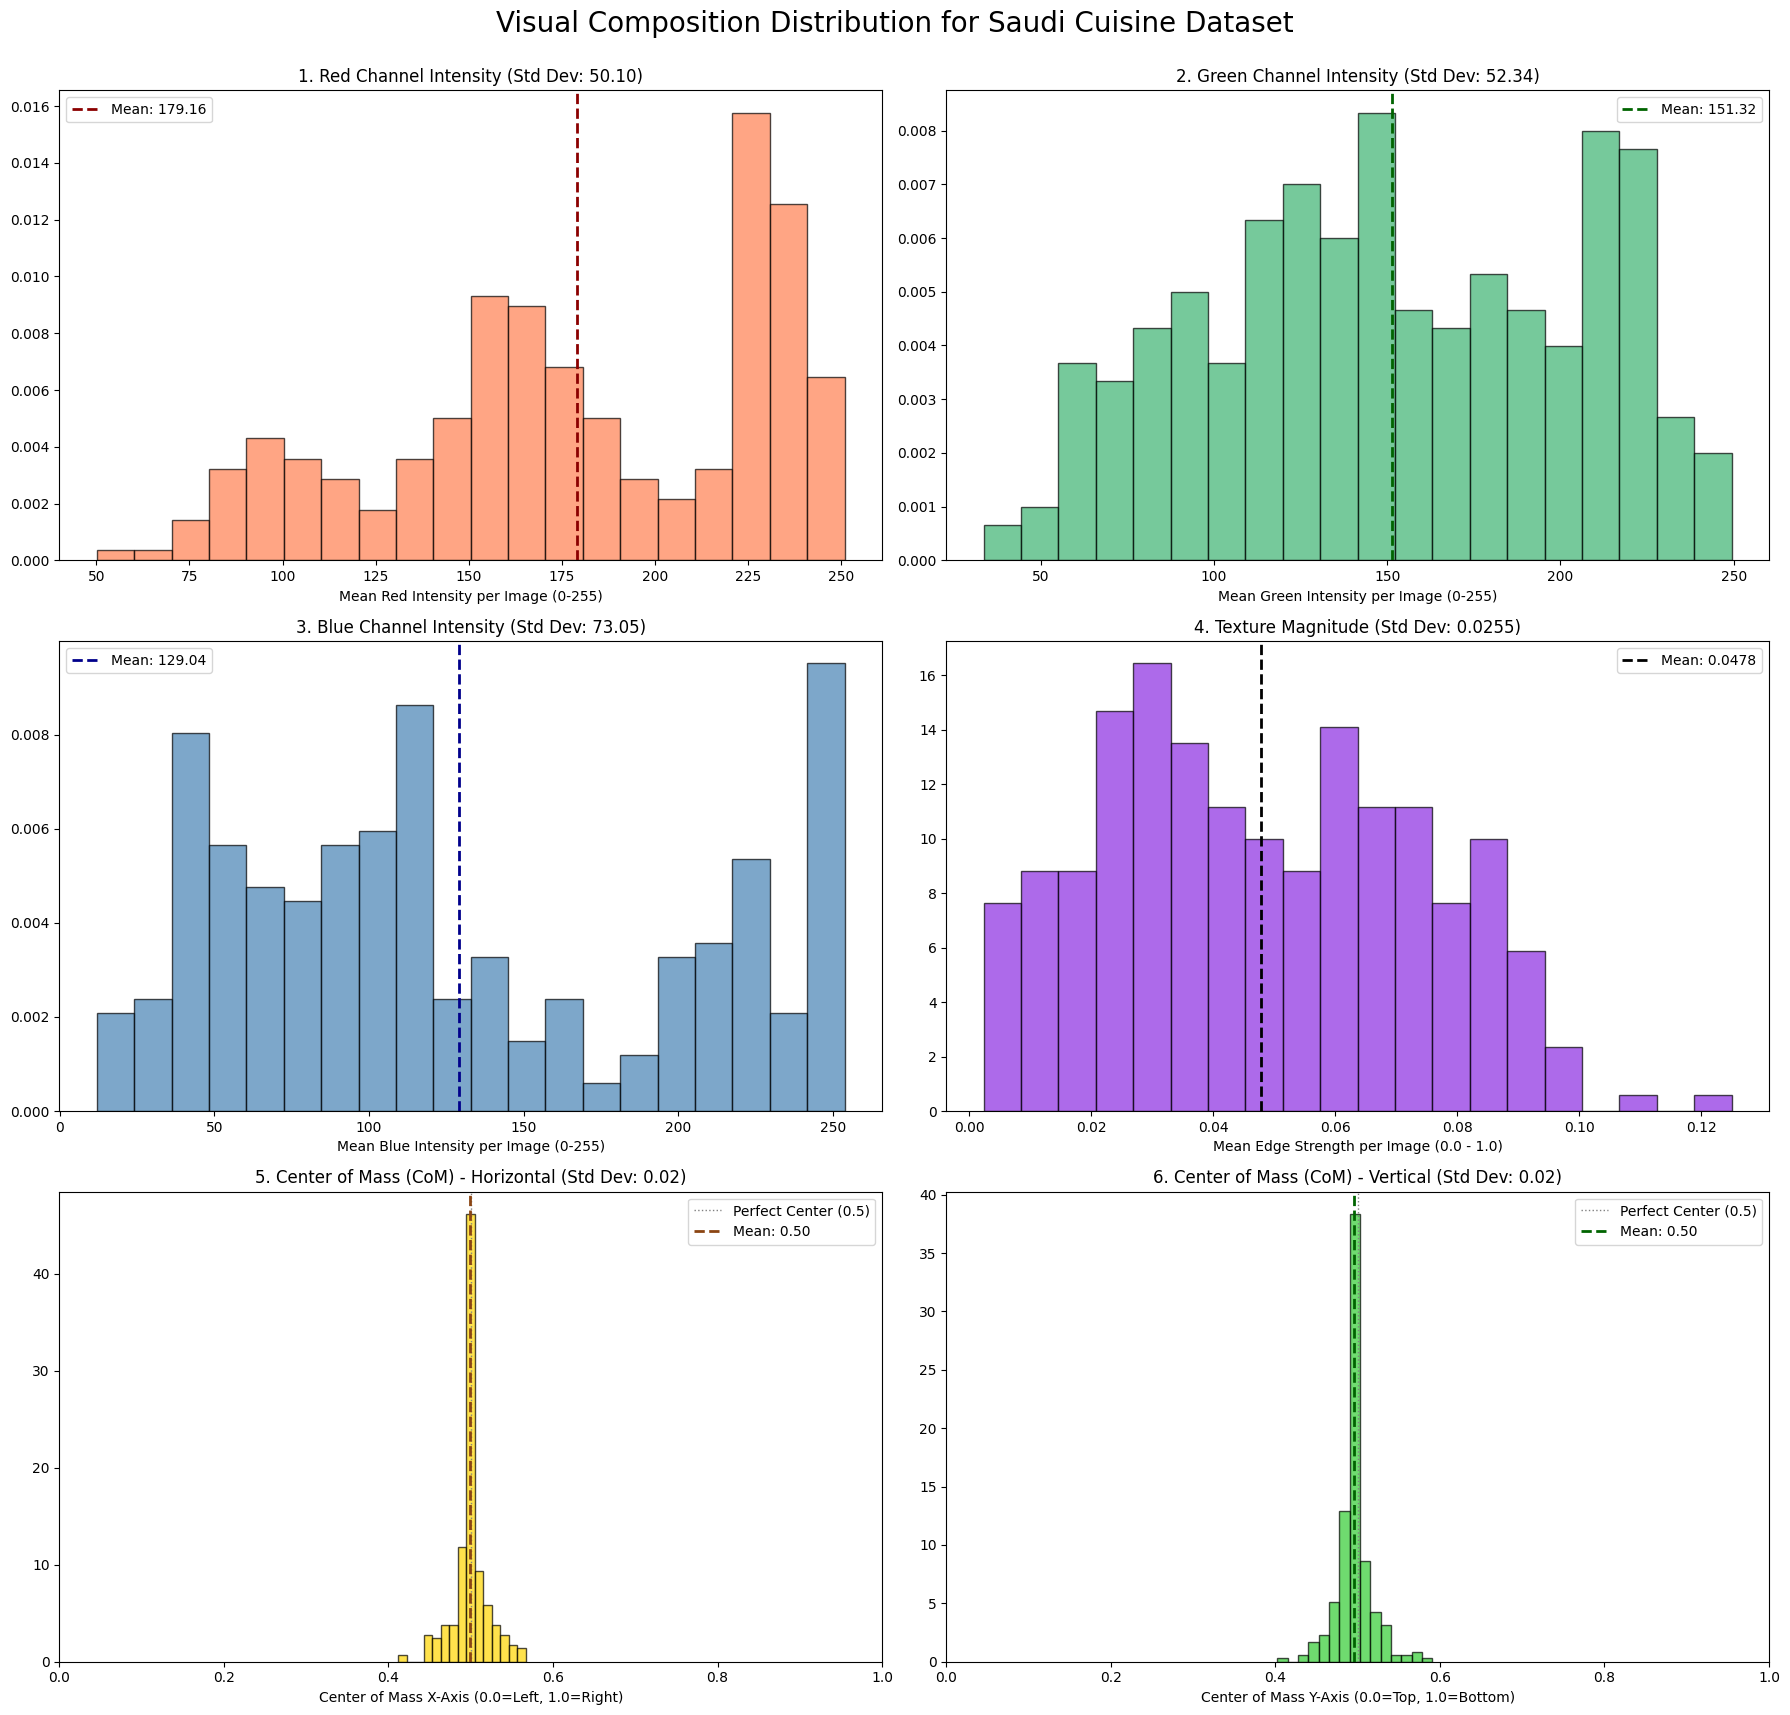


--- Saudi Cuisine Visual Analysis Complete ---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
from skimage.filters import sobel
from scipy.ndimage import center_of_mass
import zipfile
import ast

# --- Configuration ---
# Saudi Cuisine Dataset
SAUDI_CSV_PATH = 'SaudiFoodFile_standardized_consistentM.csv'  # Update with your CSV path
SAUDI_IMAGE_ZIP = 'renamed_images-2.zip'
SAUDI_EXTRACT_DIR = './extracted_saudi_images/'
SAUDI_NAME = 'Saudi Cuisine Dataset'
TARGET_SIZE = (224, 224, 3)  # Same size as N5K analysis

# --- 1. Data Loading Functions ---

def extract_saudi_images():
    """Extracts Saudi cuisine images from ZIP file."""
    if not os.path.exists(SAUDI_IMAGE_ZIP):
        print(f"Error: ZIP file {SAUDI_IMAGE_ZIP} not found!")
        return False

    os.makedirs(SAUDI_EXTRACT_DIR, exist_ok=True)

    if os.listdir(SAUDI_EXTRACT_DIR):
        print(f"Images already extracted to {SAUDI_EXTRACT_DIR}")
        return True

    print(f"Extracting {SAUDI_IMAGE_ZIP} to {SAUDI_EXTRACT_DIR}...")
    try:
        with zipfile.ZipFile(SAUDI_IMAGE_ZIP, 'r') as zip_ref:
            zip_ref.extractall(SAUDI_EXTRACT_DIR)
        print("Extraction completed successfully!")
        return True
    except Exception as e:
        print(f"Error extracting ZIP file: {e}")
        return False

def load_saudi_metadata():
    """Loads and processes the Saudi cuisine metadata from CSV."""
    df = pd.read_csv(SAUDI_CSV_PATH)

    # Process ingredients from classifications_std_list
    def extract_ingredients(ingredient_list):
        try:
            if isinstance(ingredient_list, str):
                return ast.literal_eval(ingredient_list)
            return ingredient_list
        except:
            return []

    df['ingredients_list'] = df['classifications_std_list'].apply(extract_ingredients)
    df['num_ingredients'] = df['ingredients_list'].apply(len)

    return df

def load_saudi_samples():
    """Loads Saudi cuisine images from the extracted directory."""
    # First extract images
    if not extract_saudi_images():
        return np.array([]), pd.DataFrame()

    images = []
    df = load_saudi_metadata()

    print(f"Loading Saudi cuisine images from {SAUDI_EXTRACT_DIR}...")

    # Count successful loads
    loaded_count = 0
    missing_count = 0

    # Iterate through all files in the extracted directory
    for filename in os.listdir(SAUDI_EXTRACT_DIR):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            filepath = os.path.join(SAUDI_EXTRACT_DIR, filename)
            try:
                # Load image
                img = imread(filepath)
                # Resize the image to match standard size
                img_resized = resize(img, TARGET_SIZE, anti_aliasing=True, preserve_range=True)

                # Ensure the image has 3 color channels
                if img_resized.ndim == 3 and img_resized.shape[-1] == 4:
                    img_resized = img_resized[:, :, :3]
                elif img_resized.ndim == 2:
                    img_resized = np.stack([img_resized, img_resized, img_resized], axis=-1)

                # Ensure final output is uint8
                images.append(img_resized.astype(np.uint8))
                loaded_count += 1

            except Exception as e:
                print(f"Could not load or process image {filename}: {e}")
                missing_count += 1

    print(f"Successfully loaded {loaded_count} images")
    if missing_count > 0:
        print(f"Failed to load {missing_count} images")

    return np.array(images), df

# --- 2. Analysis Functions (EXACTLY same as N5K) ---

def calculate_mean_texture(image_array):
    """Calculates the average texture magnitude across the entire dataset (for summary)."""
    if image_array.size == 0:
        return 0.0

    # Normalize pixel values to 0-1 range
    image_array = image_array.astype(np.float32) / 255.0

    # Calculate Sobel edges for all images in the array
    texture_mags = []
    for img in image_array:
        img_gray = np.mean(img, axis=2)  # Convert to grayscale
        edges = sobel(img_gray)  # Calculate edge magnitude
        texture_mags.append(np.mean(edges))  # Store average edge strength

    return np.mean(texture_mags)

def calculate_all_per_image_metrics(image_array):
    """
    Calculates the mean R, G, B, Texture, and Center of Mass for *each individual image*
    to build the distribution plot data.
    """
    if image_array.size == 0:
        return {'R': [], 'G': [], 'B': [], 'Texture': [], 'CoM_X': [], 'CoM_Y': []}

    N = image_array.shape[0]
    R, G, B, Texture, CoM_X, CoM_Y = [], [], [], [], [], []

    # Iterate over each image
    for i in range(N):
        # Normalize to 0-1 float range
        img = image_array[i].astype(np.float32) / 255.0

        # 1. COLOR (R, G, B)
        mean_rgb = np.mean(img, axis=(0, 1)) * 255
        R.append(mean_rgb[0])
        G.append(mean_rgb[1])
        B.append(mean_rgb[2])

        # 2. TEXTURE (Edge Strength)
        img_gray = np.mean(img, axis=2)  # Convert to grayscale
        edges = sobel(img_gray)  # Calculate edge magnitude
        Texture.append(np.mean(edges))  # Store average edge strength

        # 3. SPATIAL ARRANGEMENT (Center of Mass - CoM)
        # We use the grayscale image (intensity) as the "mass" map
        # CoM returns (Y_index, X_index)
        com_y, com_x = center_of_mass(img_gray)

        # Normalize CoM coordinates to range from 0.0 (left/top) to 1.0 (right/bottom)
        normalized_com_x = com_x / img.shape[1]
        normalized_com_y = com_y / img.shape[0]

        CoM_X.append(normalized_com_x)
        CoM_Y.append(normalized_com_y)

    return {'R': R, 'G': G, 'B': B, 'Texture': Texture, 'CoM_X': CoM_X, 'CoM_Y': CoM_Y}

# --- 3. Visualization Function (EXACTLY same as N5K) ---

def visualize_distribution_plots(metrics_data, dataset_name):
    """Generates histograms showing the distribution of all 5 visual features."""

    # Data extraction
    R_data = metrics_data['R']
    G_data = metrics_data['G']
    B_data = metrics_data['B']
    Texture_data = metrics_data['Texture']
    CoM_X_data = metrics_data['CoM_X']
    CoM_Y_data = metrics_data['CoM_Y']

    # 3 rows and 2 columns for six separate plots
    fig, axes = plt.subplots(3, 2, figsize=(18, 18))
    fig.suptitle(f'Visual Composition Distribution for {dataset_name}', fontsize=20)

    # Flatten the axes array for easier indexing: ax[0] to ax[5]
    ax = axes.flatten()

    # --- Plot 1: Red Channel Distribution (Color Warmth) ---
    ax[0].hist(R_data, bins=20, density=True, color='#FF7F50', alpha=0.7, edgecolor='black')
    mean_r = np.mean(R_data); std_r = np.std(R_data)
    ax[0].axvline(mean_r, color='darkred', linestyle='dashed', linewidth=2, label=f'Mean: {mean_r:.2f}')
    ax[0].set_xlabel('Mean Red Intensity per Image (0-255)')
    ax[0].set_title(f'1. Red Channel Intensity (Std Dev: {std_r:.2f})')
    ax[0].legend()

    # --- Plot 2: Green Channel Distribution (Freshness/Saturation) ---
    ax[1].hist(G_data, bins=20, density=True, color='#3CB371', alpha=0.7, edgecolor='black')
    mean_g = np.mean(G_data); std_g = np.std(G_data)
    ax[1].axvline(mean_g, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_g:.2f}')
    ax[1].set_xlabel('Mean Green Intensity per Image (0-255)')
    ax[1].set_title(f'2. Green Channel Intensity (Std Dev: {std_g:.2f})')
    ax[1].legend()

    # --- Plot 3: Blue Channel Distribution (Coolness/Background) ---
    ax[2].hist(B_data, bins=20, density=True, color='#4682B4', alpha=0.7, edgecolor='black')
    mean_b = np.mean(B_data); std_b = np.std(B_data)
    ax[2].axvline(mean_b, color='darkblue', linestyle='dashed', linewidth=2, label=f'Mean: {mean_b:.2f}')
    ax[2].set_xlabel('Mean Blue Intensity per Image (0-255)')
    ax[2].set_title(f'3. Blue Channel Intensity (Std Dev: {std_b:.2f})')
    ax[2].legend()

    # --- Plot 4: Texture Distribution (Complexity) ---
    ax[3].hist(Texture_data, bins=20, density=True, color='#8A2BE2', alpha=0.7, edgecolor='black')
    mean_t = np.mean(Texture_data); std_t = np.std(Texture_data)
    ax[3].axvline(mean_t, color='black', linestyle='dashed', linewidth=2, label=f'Mean: {mean_t:.4f}')
    ax[3].set_xlabel('Mean Edge Strength per Image (0.0 - 1.0)')
    ax[3].set_title(f'4. Texture Magnitude (Std Dev: {std_t:.4f})')
    ax[3].legend()

    # --- Plot 5: Spatial Arrangement - CoM X (Horizontal Plating) ---
    ax[4].hist(CoM_X_data, bins=15, density=True, color='#FFD700', alpha=0.7, edgecolor='black')
    mean_x = np.mean(CoM_X_data); std_x = np.std(CoM_X_data)
    ax[4].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[4].axvline(mean_x, color='saddlebrown', linestyle='dashed', linewidth=2, label=f'Mean: {mean_x:.2f}')
    ax[4].set_xlabel('Center of Mass X-Axis (0.0=Left, 1.0=Right)')
    ax[4].set_title(f'5. Center of Mass (CoM) - Horizontal (Std Dev: {std_x:.2f})')
    ax[4].legend()
    ax[4].set_xlim(0.0, 1.0)  # Ensure scale is 0 to 1 for normalized coords

    # --- Plot 6: Spatial Arrangement - CoM Y (Vertical Plating) ---
    ax[5].hist(CoM_Y_data, bins=15, density=True, color='#32CD32', alpha=0.7, edgecolor='black')
    mean_y = np.mean(CoM_Y_data); std_y = np.std(CoM_Y_data)
    ax[5].axvline(0.5, color='gray', linestyle='dotted', linewidth=1, label='Perfect Center (0.5)')
    ax[5].axvline(mean_y, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Mean: {mean_y:.2f}')
    ax[5].set_xlabel('Center of Mass Y-Axis (0.0=Top, 1.0=Bottom)')
    ax[5].set_title(f'6. Center of Mass (CoM) - Vertical (Std Dev: {std_y:.2f})')
    ax[5].legend()
    ax[5].set_xlim(0.0, 1.0)  # Ensure scale is 0 to 1 for normalized coords

    fig.tight_layout(rect=[0, 0.03, 1, 0.98])  # Adjust layout
    plt.show()

# --- Main Execution ---

print("--- Starting Saudi Cuisine Visual Composition Analysis ---")

# 1. Load Saudi Sample Data
saudi_samples, df = load_saudi_samples()
if saudi_samples.size == 0:
    print("Cannot proceed with Saudi sample data. Check your files.")
    exit()

print(f"Saudi Samples Loaded: {saudi_samples.shape[0]} images.")

# 2. Calculate ALL Per-Image Metrics for Distribution Plots
all_metrics = calculate_all_per_image_metrics(saudi_samples)
print("Calculated per-image metrics for R, G, B, Texture, and CoM.")

# 3. Calculate Mean Texture (for simple summary)
saudi_mean_texture_summary = calculate_mean_texture(saudi_samples)

print("\n--- Summary of Saudi Dataset Averages ---")
# Calculate mean RGB for quick print
mean_r_summary = np.mean(all_metrics['R'])
mean_g_summary = np.mean(all_metrics['G'])
mean_b_summary = np.mean(all_metrics['B'])

print(f"Mean R/G/B Signature: R={mean_r_summary:.2f}, G={mean_g_summary:.2f}, B={mean_b_summary:.2f}")
print(f"Mean Texture (0-1): {saudi_mean_texture_summary:.4f}")
print(f"Mean CoM (X/Y): X={np.mean(all_metrics['CoM_X']):.2f}, Y={np.mean(all_metrics['CoM_Y']):.2f}")

# 4. Visualize Distribution
print("\nDisplaying Distribution Plots (Histograms/Bell Curve)...")
visualize_distribution_plots(all_metrics, SAUDI_NAME)

print("\n--- Saudi Cuisine Visual Analysis Complete ---")

# Key Findings :

1.	Color Distribution (R/G/B Channels)
The Saudi Cuisine dataset shows a balanced color composition with slight dominance in warm tones (Red mean ≈ 179.16), followed by Green (151.32) and Blue (129.04).
This indicates that many dishes contain ingredients and plating styles rich in browns, yellows, and reds, typically associated with cooked grains, meats, and spices.
The moderate variation (standard deviation ≈ 50–70) suggests visual diversity among dishes but with consistent color harmony.



2.	Texture Magnitude Analysis
The average edge strength is 0.0478, indicating moderate surface detail across dishes.
Dishes show visible texture—neither too flat nor overly detailed—suggesting balanced presentation between smooth sauces and textured toppings.
Texture distribution is wide, representing both soft desserts and detailed main dishes such as Kabsa and Shawarma.



3.	Spatial Composition (Center of Mass)
The horizontal (X) and vertical (Y) centers of mass both average around 0.50, meaning that the dishes are well-centered in their images.
This demonstrates high photographic consistency, with most dishes framed symmetrically.
Low standard deviation (≈0.02) confirms that there are no major shifts or cropping biases in the visual dataset.




4.	Overall Insights
The Saudi cuisine images exhibit natural color warmth, balanced framing, and moderate textural detail.

#COMPARISON


STARTING CROSS-CUISINE COMPARISON ANALYSIS
Nutrition5k analysis not found. Running quick N5K analysis...
Loading images from ./rgb_samples_fixed/...
✅ Both datasets loaded successfully for comparison!

1. Comparing color profiles...


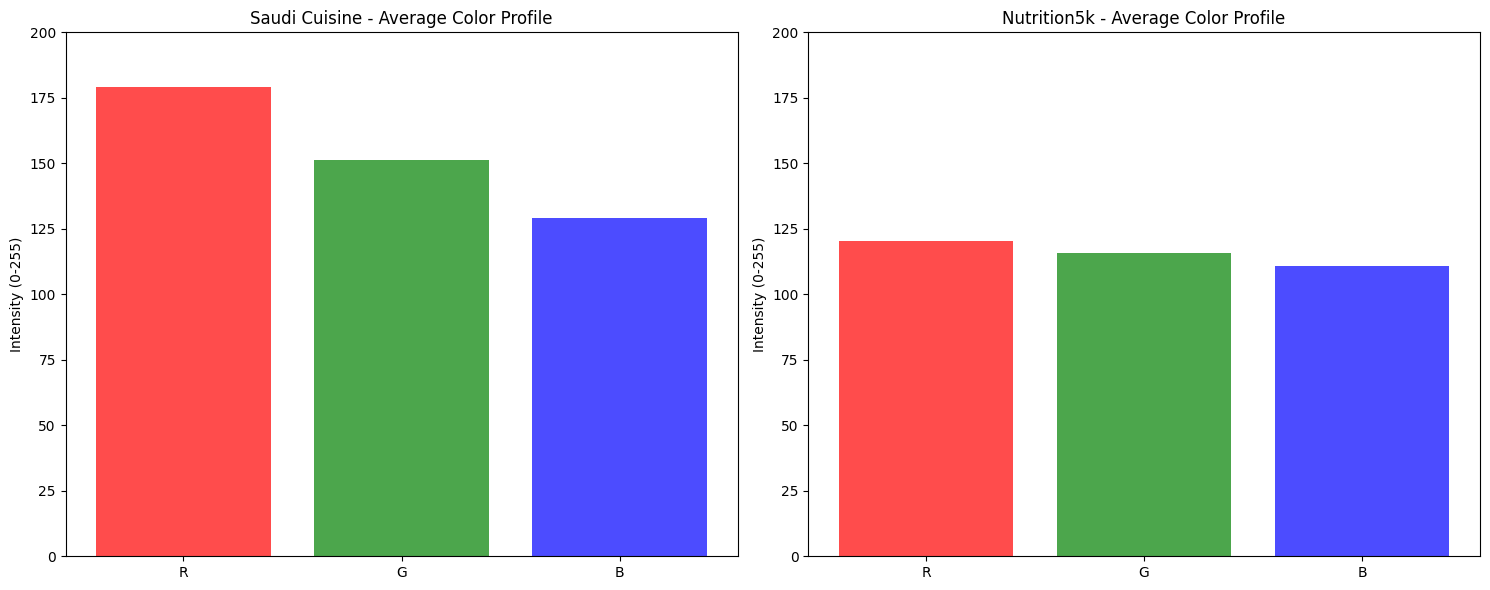


2. Comparing plating patterns...


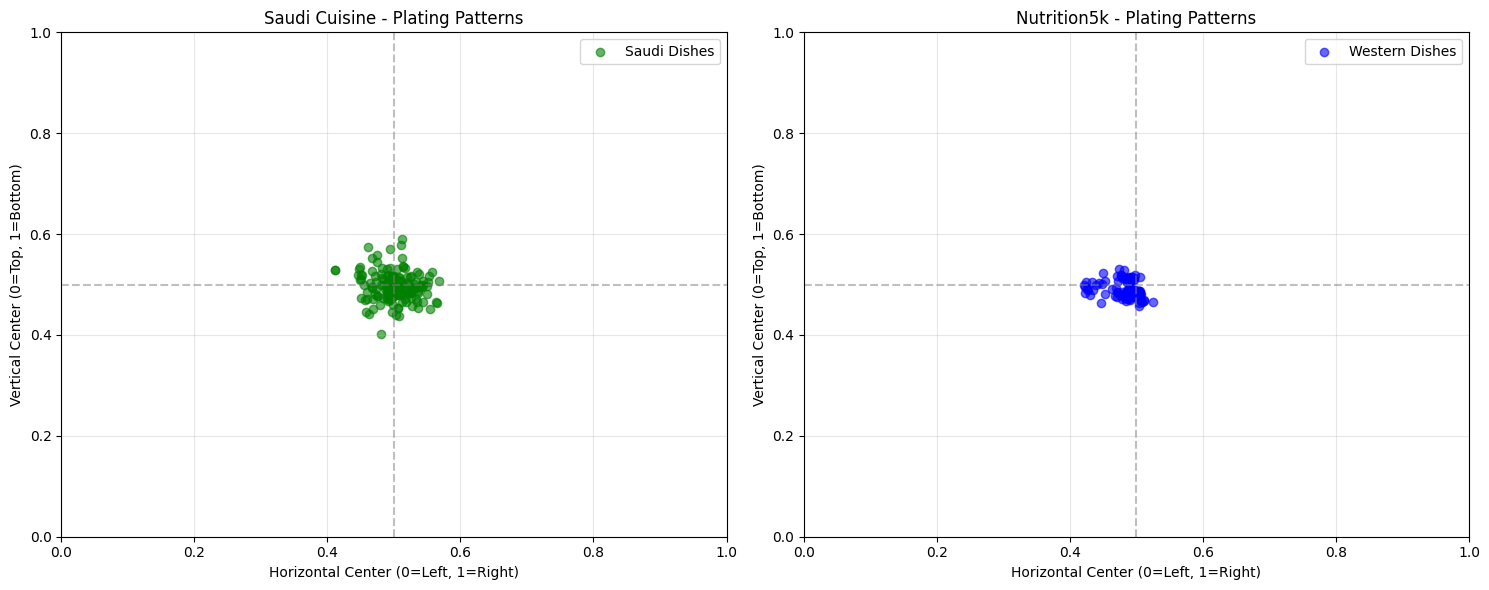


3. Comparing texture complexity...


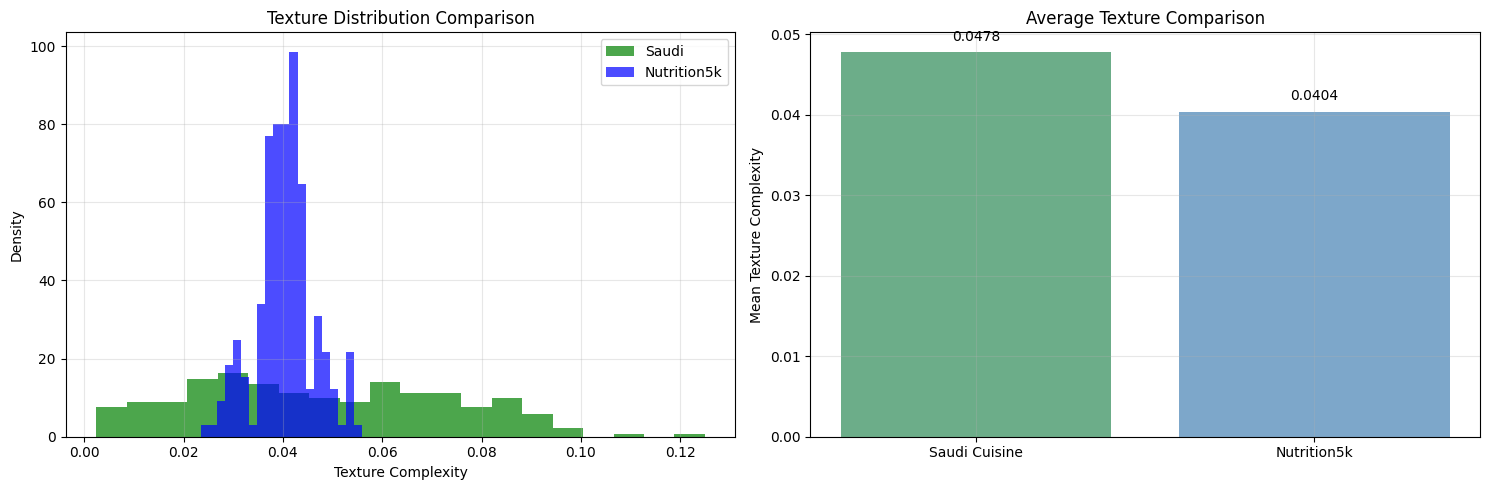


4. Cross-cuisine feature comparison...
Cross-Cuisine Visual Feature Comparison:
              Feature  Saudi_Cuisine  Nutrition5k
0       Red Intensity        179.160      120.165
1     Green Intensity        151.320      115.667
2      Blue Intensity        129.041      110.942
3  Texture Complexity          0.048        0.040
4  Horizontal Balance          0.499        0.490
5    Vertical Balance          0.496        0.487


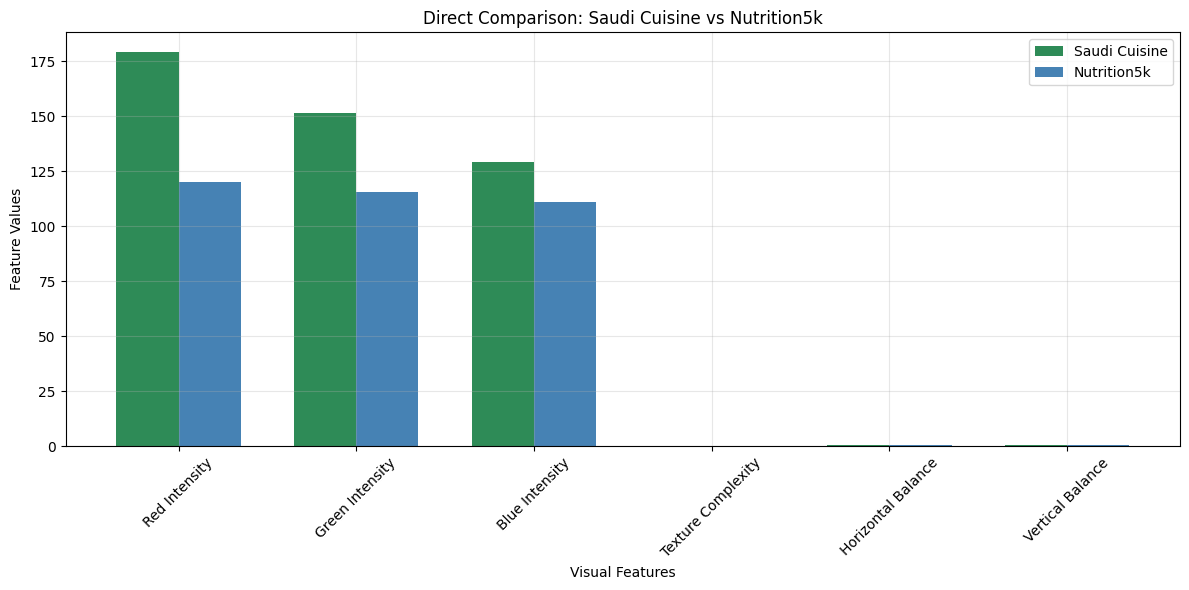


KEY COMPARISON INSIGHTS
🎨 Color Differences:
   Saudi dishes are warmer than Nutrition5k dishes
   Saudi green intensity: 151.3 vs N5K: 115.7
🔍 Texture Differences:
   Saudi dishes are more textured than Nutrition5k dishes
   Texture ratio: 1.18x
📐 Plating Differences:
   Saudi dishes are centered at X: 0.499 vs N5K: 0.490

COMPARISON ANALYSIS COMPLETE!


In [ ]:
# --- ADD THESE COMPARISON FUNCTIONS ---

def compare_cuisine_color_profiles(saudi_metrics, n5k_metrics):
    """Compare color signatures between Saudi and Western cuisines"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Saudi cuisine colors
    axes[0].bar(['R', 'G', 'B'],
                [np.mean(saudi_metrics['R']), np.mean(saudi_metrics['G']), np.mean(saudi_metrics['B'])],
                color=['red', 'green', 'blue'], alpha=0.7)
    axes[0].set_title('Saudi Cuisine - Average Color Profile')
    axes[0].set_ylabel('Intensity (0-255)')
    axes[0].set_ylim(0, 200)

    # Nutrition5k colors
    axes[1].bar(['R', 'G', 'B'],
                [np.mean(n5k_metrics['R']), np.mean(n5k_metrics['G']), np.mean(n5k_metrics['B'])],
                color=['red', 'green', 'blue'], alpha=0.7)
    axes[1].set_title('Nutrition5k - Average Color Profile')
    axes[1].set_ylabel('Intensity (0-255)')
    axes[1].set_ylim(0, 200)

    plt.tight_layout()
    plt.show()

def compare_plating_patterns(saudi_com_metrics, n5k_com_metrics):
    """Compare spatial arrangement (plating styles) between cuisines"""

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Saudi cuisine plating
    axes[0].scatter(saudi_com_metrics['CoM_X'], saudi_com_metrics['CoM_Y'],
                   alpha=0.6, color='green', label='Saudi Dishes')
    axes[0].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1)
    axes[0].set_xlabel('Horizontal Center (0=Left, 1=Right)')
    axes[0].set_ylabel('Vertical Center (0=Top, 1=Bottom)')
    axes[0].set_title('Saudi Cuisine - Plating Patterns')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Nutrition5k plating
    axes[1].scatter(n5k_com_metrics['CoM_X'], n5k_com_metrics['CoM_Y'],
                   alpha=0.6, color='blue', label='Western Dishes')
    axes[1].axhline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].axvline(0.5, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].set_xlabel('Horizontal Center (0=Left, 1=Right)')
    axes[1].set_ylabel('Vertical Center (0=Top, 1=Bottom)')
    axes[1].set_title('Nutrition5k - Plating Patterns')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def cross_cuisine_comparison(saudi_metrics, n5k_metrics):
    """Direct statistical comparison between cuisines"""

    comparison_data = {
        'Feature': ['Red Intensity', 'Green Intensity', 'Blue Intensity',
                   'Texture Complexity', 'Horizontal Balance', 'Vertical Balance'],
        'Saudi_Cuisine': [
            np.mean(saudi_metrics['R']), np.mean(saudi_metrics['G']), np.mean(saudi_metrics['B']),
            np.mean(saudi_metrics['Texture']), np.mean(saudi_metrics['CoM_X']), np.mean(saudi_metrics['CoM_Y'])
        ],
        'Nutrition5k': [
            np.mean(n5k_metrics['R']), np.mean(n5k_metrics['G']), np.mean(n5k_metrics['B']),
            np.mean(n5k_metrics['Texture']), np.mean(n5k_metrics['CoM_X']), np.mean(n5k_metrics['CoM_Y'])
        ]
    }

    comparison_df = pd.DataFrame(comparison_data)
    print("Cross-Cuisine Visual Feature Comparison:")
    print(comparison_df.round(3))

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    x = np.arange(len(comparison_data['Feature']))
    width = 0.35

    ax.bar(x - width/2, comparison_data['Saudi_Cuisine'], width, label='Saudi Cuisine', color='#2E8B57')
    ax.bar(x + width/2, comparison_data['Nutrition5k'], width, label='Nutrition5k', color='#4682B4')

    ax.set_xlabel('Visual Features')
    ax.set_ylabel('Feature Values')
    ax.set_title('Direct Comparison: Saudi Cuisine vs Nutrition5k')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_data['Feature'], rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return comparison_df

def compare_texture_complexity(saudi_metrics, n5k_metrics):
    """Compare texture complexity between cuisines"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Texture distribution comparison
    ax1.hist(saudi_metrics['Texture'], bins=20, alpha=0.7, color='green', label='Saudi', density=True)
    ax1.hist(n5k_metrics['Texture'], bins=20, alpha=0.7, color='blue', label='Nutrition5k', density=True)
    ax1.set_xlabel('Texture Complexity')
    ax1.set_ylabel('Density')
    ax1.set_title('Texture Distribution Comparison')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Mean texture comparison
    cuisines = ['Saudi Cuisine', 'Nutrition5k']
    mean_textures = [np.mean(saudi_metrics['Texture']), np.mean(n5k_metrics['Texture'])]
    colors = ['#2E8B57', '#4682B4']

    bars = ax2.bar(cuisines, mean_textures, color=colors, alpha=0.7)
    ax2.set_ylabel('Mean Texture Complexity')
    ax2.set_title('Average Texture Comparison')
    ax2.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, mean_textures):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# --- ADD THIS TO YOUR MAIN EXECUTION AFTER BOTH ANALYSES ARE COMPLETE ---

print("\n" + "="*60)
print("STARTING CROSS-CUISINE COMPARISON ANALYSIS")
print("="*60)

# Make sure you have both Saudi and Nutrition5k metrics available
# If you don't have n5k_metrics from previous analysis, you need to load Nutrition5k data first

# Load Nutrition5k metrics (you need to run your Nutrition5k analysis first to get this)
# Here's a quick way to get n5k_metrics if you haven't already:

def load_n5k_metrics():
    """Load Nutrition5k metrics - you need to have run the N5K analysis first"""
    try:
        # If you already ran the Nutrition5k analysis, these variables should exist
        return n5k_samples, all_metrics_n5k
    except NameError:
        print("Nutrition5k analysis not found. Running quick N5K analysis...")
        # Run a quick version of your N5K analysis here
        n5k_samples = load_local_nutrition5k_samples()
        if n5k_samples.size == 0:
            print("Cannot load Nutrition5k data for comparison")
            return None, None
        all_metrics_n5k = calculate_all_per_image_metrics(n5k_samples)
        return n5k_samples, all_metrics_n5k

# Load Nutrition5k data for comparison
n5k_samples, n5k_metrics = load_n5k_metrics()

if n5k_metrics is not None and saudi_samples.size > 0:
    print("✅ Both datasets loaded successfully for comparison!")

    # Now run the comparison visualizations
    print("\n1. Comparing color profiles...")
    compare_cuisine_color_profiles(all_metrics, n5k_metrics)

    print("\n2. Comparing plating patterns...")
    compare_plating_patterns(all_metrics, n5k_metrics)

    print("\n3. Comparing texture complexity...")
    compare_texture_complexity(all_metrics, n5k_metrics)

    print("\n4. Cross-cuisine feature comparison...")
    comparison_results = cross_cuisine_comparison(all_metrics, n5k_metrics)

    # Additional insights
    print("\n" + "="*50)
    print("KEY COMPARISON INSIGHTS")
    print("="*50)

    saudi_red = np.mean(all_metrics['R'])
    n5k_red = np.mean(n5k_metrics['R'])
    saudi_green = np.mean(all_metrics['G'])
    n5k_green = np.mean(n5k_metrics['G'])
    saudi_texture = np.mean(all_metrics['Texture'])
    n5k_texture = np.mean(n5k_metrics['Texture'])

    print(f"🎨 Color Differences:")
    print(f"   Saudi dishes are {'warmer' if saudi_red > n5k_red else 'cooler'} than Nutrition5k dishes")
    print(f"   Saudi green intensity: {saudi_green:.1f} vs N5K: {n5k_green:.1f}")

    print(f"🔍 Texture Differences:")
    print(f"   Saudi dishes are {'more' if saudi_texture > n5k_texture else 'less'} textured than Nutrition5k dishes")
    print(f"   Texture ratio: {saudi_texture/n5k_texture:.2f}x")

    print(f"📐 Plating Differences:")
    saudi_center_x = np.mean(all_metrics['CoM_X'])
    n5k_center_x = np.mean(n5k_metrics['CoM_X'])
    print(f"   Saudi dishes are centered at X: {saudi_center_x:.3f} vs N5K: {n5k_center_x:.3f}")

else:
    print("❌ Cannot perform comparison - one or both datasets missing")
    if saudi_samples.size == 0:
        print("   - Saudi data not loaded")
    if n5k_metrics is None:
        print("   - Nutrition5k data not loaded")

print("\n" + "="*60)
print("COMPARISON ANALYSIS COMPLETE!")
print("="*60)

From the comparative analysis conducted above, we notice some distinction between our data and the general food patterns found in Nutrition5K. The higher mean intensity of the red and green colors in the Saudi dataset can be attributed to the generous and frequent use of spices, such as tumeric and saffron, as well as aromatic herbs in the preparation of many traditional Saudi dishes.

Furthermore, the higher average texture in Saudi food is representative of the traditional plating style of Saudi dishes where components such as rice, meat, and toppings are piled rather than scattered like in Western dishes.

These findings suggest that our model will need to be better attuned to the texture-based traits and wamer color palettes of the Saudi cuisine.  